In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from collections import namedtuple

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-sys-2-2-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/systematics/nugen_h5/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


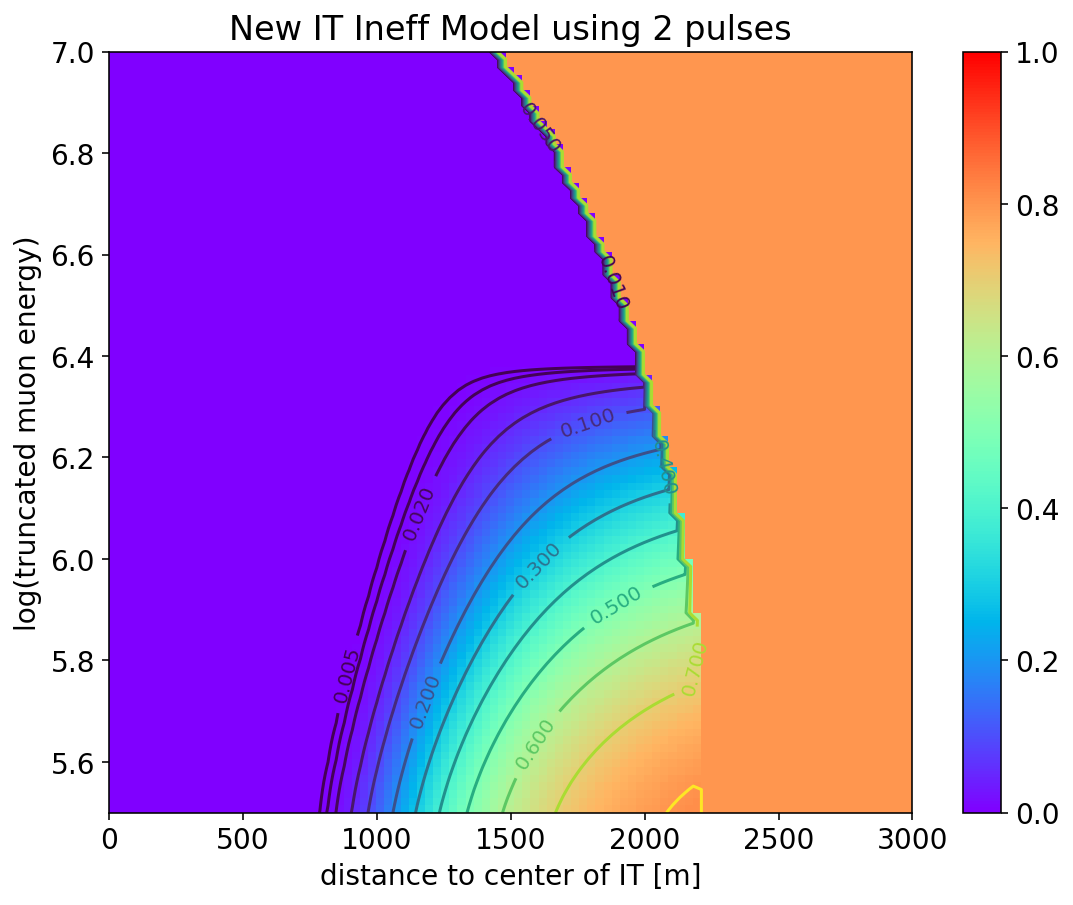

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

# read MC

In [5]:
# all nugen datasets:
nugen = {}

In [6]:
""" 11883 """

variation = [
    'nugen_11883_clsim-base-4.0.5-ellipse-abs.01.1.09_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-abs.01.0.89_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-abs.01.0.99_eff.h5',
    
    'nugen_11883_clsim-base-4.0.5-ellipse-scat.01.1.09_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-scat.01.0.89_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-scat.01.0.99_eff.h5',
    
    'nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.1.09_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.0.89_eff.h5',
    'nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.0.99_eff.h5',
]

nfiles = [19994,
          19998,
         19994,
          
         19991,
         19996,
         19994,
          
         19994,
         19993,
         19994,
         ]


names = ['abs_DOM_up',
        'abs_DOM_down',
        'abs_DOM_nominal',
        
         'scat_DOM_up',
        'scat_DOM_down',
        'scat_DOM_nominal',
         
         'both_DOM_up',
        'both_DOM_down',
        'both_DOM_nominal',
        ]

for _variation,_nfile,_name in zip(variation,nfiles,names):
    dic = {}
    nfile = _nfile
    
    with tables.open_file(data_dir+'11883/'+_variation,'r') as f:

        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
        CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#         CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < 0.2   
        
        CUT_ineff = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])) < 0.01
        CUT_stoch = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
        
        CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_ineff & CUT_stoch
        
        dic['E_resolution'] = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:]))[CUT] 
        dic['chi2_red_new'] = f.root.Collection.cols.chi2_red_new[:][CUT]
        dic['zenith'] = f.root.SplineMPE.cols.zenith[:][CUT]
        dic['truncated'] = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        dic['NPE'] = f.root.QTot.cols.value[:][CUT]
        dic['coincidence'] = f.root.MCPrimary_coincident.cols.value[:][CUT]
        dic['prim_e'] = f.root.MCPrimary_new.cols.energy[:][CUT]
        dic['zenith_truth'] = f.root.MCPrimary_new.cols.zenith[:][CUT]

        dic['weight_conv'] = f.root.weight_honda2006[:][CUT] * lifetime/nfile  * 2
        dic['weight_prompt'] = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/nfile  * 2

        ### astrophysical ###
        energy = f.root.MCPrimary_new.cols.energy[:][CUT]
        OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
        NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
        dic['weight_astro'] = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(nfile * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

        dic['runid'] = f.root.I3EventHeader.cols.Run[:][CUT]
        dic['eventid'] = f.root.I3EventHeader.cols.Event[:][CUT]
    # convert to dataframe
    
    def ntuples():
        list_of_names = df.columns.values
        list_of_names_dict = {x:x for x in list_of_names}

        Varnames = namedtuple('Varnames', list_of_names) 
        return Varnames(**list_of_names_dict)    
    df = pd.DataFrame(dic)
    v = ntuples()

    nugen['bulkice_'+_name+'_11883'] = df

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [7]:
merged_abs_DOM_up_11883_zenith = np.concatenate((nugen['bulkice_abs_DOM_up_11883']['zenith'],nugen['bulkice_abs_DOM_up_11883']['zenith'],nugen['bulkice_abs_DOM_up_11883']['zenith']))
merged_abs_DOM_up_11883_energy = np.concatenate((nugen['bulkice_abs_DOM_up_11883']['truncated'],nugen['bulkice_abs_DOM_up_11883']['truncated'],nugen['bulkice_abs_DOM_up_11883']['truncated']))
merged_abs_DOM_up_11883_weight = np.concatenate((nugen['bulkice_abs_DOM_up_11883']['weight_astro'],nugen['bulkice_abs_DOM_up_11883']['weight_conv'],nugen['bulkice_abs_DOM_up_11883']['weight_prompt']))

merged_abs_DOM_down_11883_zenith = np.concatenate((nugen['bulkice_abs_DOM_down_11883']['zenith'],nugen['bulkice_abs_DOM_down_11883']['zenith'],nugen['bulkice_abs_DOM_down_11883']['zenith']))
merged_abs_DOM_down_11883_energy = np.concatenate((nugen['bulkice_abs_DOM_down_11883']['truncated'],nugen['bulkice_abs_DOM_down_11883']['truncated'],nugen['bulkice_abs_DOM_down_11883']['truncated']))
merged_abs_DOM_down_11883_weight = np.concatenate((nugen['bulkice_abs_DOM_down_11883']['weight_astro'],nugen['bulkice_abs_DOM_down_11883']['weight_conv'],nugen['bulkice_abs_DOM_down_11883']['weight_prompt']))

merged_abs_DOM_nominal_11883_zenith = np.concatenate((nugen['bulkice_abs_DOM_nominal_11883']['zenith'],nugen['bulkice_abs_DOM_nominal_11883']['zenith'],nugen['bulkice_abs_DOM_nominal_11883']['zenith']))
merged_abs_DOM_nominal_11883_energy = np.concatenate((nugen['bulkice_abs_DOM_nominal_11883']['truncated'],nugen['bulkice_abs_DOM_nominal_11883']['truncated'],nugen['bulkice_abs_DOM_nominal_11883']['truncated']))
merged_abs_DOM_nominal_11883_weight = np.concatenate((nugen['bulkice_abs_DOM_nominal_11883']['weight_astro'],nugen['bulkice_abs_DOM_nominal_11883']['weight_conv'],nugen['bulkice_abs_DOM_nominal_11883']['weight_prompt']))

In [8]:
merged_scat_DOM_up_11883_zenith = np.concatenate((nugen['bulkice_scat_DOM_up_11883']['zenith'],nugen['bulkice_scat_DOM_up_11883']['zenith'],nugen['bulkice_scat_DOM_up_11883']['zenith']))
merged_scat_DOM_up_11883_energy = np.concatenate((nugen['bulkice_scat_DOM_up_11883']['truncated'],nugen['bulkice_scat_DOM_up_11883']['truncated'],nugen['bulkice_scat_DOM_up_11883']['truncated']))
merged_scat_DOM_up_11883_weight = np.concatenate((nugen['bulkice_scat_DOM_up_11883']['weight_astro'],nugen['bulkice_scat_DOM_up_11883']['weight_conv'],nugen['bulkice_scat_DOM_up_11883']['weight_prompt']))

merged_scat_DOM_down_11883_zenith = np.concatenate((nugen['bulkice_scat_DOM_down_11883']['zenith'],nugen['bulkice_scat_DOM_down_11883']['zenith'],nugen['bulkice_scat_DOM_down_11883']['zenith']))
merged_scat_DOM_down_11883_energy = np.concatenate((nugen['bulkice_scat_DOM_down_11883']['truncated'],nugen['bulkice_scat_DOM_down_11883']['truncated'],nugen['bulkice_scat_DOM_down_11883']['truncated']))
merged_scat_DOM_down_11883_weight = np.concatenate((nugen['bulkice_scat_DOM_down_11883']['weight_astro'],nugen['bulkice_scat_DOM_down_11883']['weight_conv'],nugen['bulkice_scat_DOM_down_11883']['weight_prompt']))

merged_scat_DOM_nominal_11883_zenith = np.concatenate((nugen['bulkice_scat_DOM_nominal_11883']['zenith'],nugen['bulkice_scat_DOM_nominal_11883']['zenith'],nugen['bulkice_scat_DOM_nominal_11883']['zenith']))
merged_scat_DOM_nominal_11883_energy = np.concatenate((nugen['bulkice_scat_DOM_nominal_11883']['truncated'],nugen['bulkice_scat_DOM_nominal_11883']['truncated'],nugen['bulkice_scat_DOM_nominal_11883']['truncated']))
merged_scat_DOM_nominal_11883_weight = np.concatenate((nugen['bulkice_scat_DOM_nominal_11883']['weight_astro'],nugen['bulkice_scat_DOM_nominal_11883']['weight_conv'],nugen['bulkice_scat_DOM_nominal_11883']['weight_prompt']))

In [9]:
merged_both_DOM_up_11883_zenith = np.concatenate((nugen['bulkice_both_DOM_up_11883']['zenith'],nugen['bulkice_both_DOM_up_11883']['zenith'],nugen['bulkice_both_DOM_up_11883']['zenith']))
merged_both_DOM_up_11883_energy = np.concatenate((nugen['bulkice_both_DOM_up_11883']['truncated'],nugen['bulkice_both_DOM_up_11883']['truncated'],nugen['bulkice_both_DOM_up_11883']['truncated']))
merged_both_DOM_up_11883_weight = np.concatenate((nugen['bulkice_both_DOM_up_11883']['weight_astro'],nugen['bulkice_both_DOM_up_11883']['weight_conv'],nugen['bulkice_both_DOM_up_11883']['weight_prompt']))

merged_both_DOM_down_11883_zenith = np.concatenate((nugen['bulkice_both_DOM_down_11883']['zenith'],nugen['bulkice_both_DOM_down_11883']['zenith'],nugen['bulkice_both_DOM_down_11883']['zenith']))
merged_both_DOM_down_11883_energy = np.concatenate((nugen['bulkice_both_DOM_down_11883']['truncated'],nugen['bulkice_both_DOM_down_11883']['truncated'],nugen['bulkice_both_DOM_down_11883']['truncated']))
merged_both_DOM_down_11883_weight = np.concatenate((nugen['bulkice_both_DOM_down_11883']['weight_astro'],nugen['bulkice_both_DOM_down_11883']['weight_conv'],nugen['bulkice_both_DOM_down_11883']['weight_prompt']))

merged_both_DOM_nominal_11883_zenith = np.concatenate((nugen['bulkice_both_DOM_nominal_11883']['zenith'],nugen['bulkice_both_DOM_nominal_11883']['zenith'],nugen['bulkice_both_DOM_nominal_11883']['zenith']))
merged_both_DOM_nominal_11883_energy = np.concatenate((nugen['bulkice_both_DOM_nominal_11883']['truncated'],nugen['bulkice_both_DOM_nominal_11883']['truncated'],nugen['bulkice_both_DOM_nominal_11883']['truncated']))
merged_both_DOM_nominal_11883_weight = np.concatenate((nugen['bulkice_both_DOM_nominal_11883']['weight_astro'],nugen['bulkice_both_DOM_nominal_11883']['weight_conv'],nugen['bulkice_both_DOM_nominal_11883']['weight_prompt']))

In [10]:
""" 11883 """

domeffs = ['0.89','0.99','1.09']
nfiles = [19995,20000,19988]
names = ['down','nominal','up']

for _domeff,_nfile,_name in zip(domeffs,nfiles,names):
    dic = {}
    nfile = _nfile
    
    with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5.'+_domeff+'_eff.h5','r') as f:

        CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
        CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
        CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
        CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
        CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
        CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
        CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#         CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < 0.2   
        
        CUT_ineff = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:])) < 0.01
        CUT_stoch = np.log10(f.root.Collection.cols.chi2_red_new[:]) > 2.5
        
        CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_ineff & CUT_stoch
        
        dic['E_resolution'] = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:]))[CUT] 
        dic['chi2_red_new'] = f.root.Collection.cols.chi2_red_new[:][CUT]
        dic['zenith'] = f.root.SplineMPE.cols.zenith[:][CUT]
        dic['truncated'] = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
        dic['NPE'] = f.root.QTot.cols.value[:][CUT]
        dic['coincidence'] = f.root.MCPrimary_coincident.cols.value[:][CUT]
        dic['prim_e'] = f.root.MCPrimary_new.cols.energy[:][CUT]
        dic['zenith_truth'] = f.root.MCPrimary_new.cols.zenith[:][CUT]

        dic['weight_conv'] = f.root.weight_honda2006[:][CUT] * lifetime/nfile  * 2
        dic['weight_prompt'] = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/nfile  * 2

        ### astrophysical ###
        energy = f.root.MCPrimary_new.cols.energy[:][CUT]
        OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
        NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
        dic['weight_astro'] = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(nfile * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

        dic['runid'] = f.root.I3EventHeader.cols.Run[:][CUT]
        dic['eventid'] = f.root.I3EventHeader.cols.Event[:][CUT]
    # convert to dataframe
    
    def ntuples():
        list_of_names = df.columns.values
        list_of_names_dict = {x:x for x in list_of_names}

        Varnames = namedtuple('Varnames', list_of_names) 
        return Varnames(**list_of_names_dict)    
    df = pd.DataFrame(dic)
    v = ntuples()

    nugen['domeff_'+_name+'_11883'] = df

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [11]:
merged_up_11883_zenith = np.concatenate((nugen['domeff_up_11883']['zenith'],nugen['domeff_up_11883']['zenith'],nugen['domeff_up_11883']['zenith']))
merged_up_11883_energy = np.concatenate((nugen['domeff_up_11883']['truncated'],nugen['domeff_up_11883']['truncated'],nugen['domeff_up_11883']['truncated']))
merged_up_11883_weight = np.concatenate((nugen['domeff_up_11883']['weight_astro'],nugen['domeff_up_11883']['weight_conv'],nugen['domeff_up_11883']['weight_prompt']))

merged_down_11883_zenith = np.concatenate((nugen['domeff_down_11883']['zenith'],nugen['domeff_down_11883']['zenith'],nugen['domeff_down_11883']['zenith']))
merged_down_11883_energy = np.concatenate((nugen['domeff_down_11883']['truncated'],nugen['domeff_down_11883']['truncated'],nugen['domeff_down_11883']['truncated']))
merged_down_11883_weight = np.concatenate((nugen['domeff_down_11883']['weight_astro'],nugen['domeff_down_11883']['weight_conv'],nugen['domeff_down_11883']['weight_prompt']))

merged_nominal_11883_zenith = np.concatenate((nugen['domeff_nominal_11883']['zenith'],nugen['domeff_nominal_11883']['zenith'],nugen['domeff_nominal_11883']['zenith']))
merged_nominal_11883_energy = np.concatenate((nugen['domeff_nominal_11883']['truncated'],nugen['domeff_nominal_11883']['truncated'],nugen['domeff_nominal_11883']['truncated']))
merged_nominal_11883_weight = np.concatenate((nugen['domeff_nominal_11883']['weight_astro'],nugen['domeff_nominal_11883']['weight_conv'],nugen['domeff_nominal_11883']['weight_prompt']))

# study distributions

In [12]:
def comparison(var,weight,bins,varname,title):
    var_nominal = var[0]
    var_abs = var[1]
    var_scat = var[2]
    var_both = var[3]

    weight_nominal = weight[0]
    weight_abs = weight[1]
    weight_scat = weight[2]
    weight_both = weight[3]

    plt.figure(figsize=(7,7))

    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
    c_abs = 'darkorange'
    c_scat = 'dodgerblue'
    c_both = 'm'
#     if 'cos' in varname:
#         c_abs = 'tomato'
#         c_scat = 'darkturquoise'
#         c_both = 'r'
    h_abs,b_abs,_ = plt.hist(var_abs,bins=bins,log=True,weights=weight_abs,histtype='step',label=r'$absorption+10\%$',bottom=10**(-8),color=c_abs)
    h_scat,b_scat,_ = plt.hist(var_scat,bins=bins,log=True,weights=weight_scat,histtype='step',label=r'$scattering+10\%$',bottom=10**(-8),color=c_scat)
    h_both,b_both,_ = plt.hist(var_both,bins=bins,log=True,weights=weight_both,histtype='step',label=r'$both-7\%$',bottom=10**(-8),color=c_both)
    h_nominal,b_nominal,_ = plt.hist(var_nominal,bins=bins,log=True,weights=weight_nominal,histtype='step',linestyle='dashed',label=r'nominal',bottom=10**(-8),color='black')

    plt.ylabel('Events in 365 days')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(np.min(h_nominal)/2,)
    plt.legend(prop={'size': 11},loc='upper left')
    plt.title(title)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    
    
    ax2 = plt.subplot(gs[1])
    
    # remove empty bins
    b = (b_nominal[1:] + b_nominal[:-1])/2
    cut_nozero = (h_nominal>0)
    b = b[cut_nozero]
    h_abs = h_abs[cut_nozero]
    h_scat = h_scat[cut_nozero]
    h_nominal = h_nominal[cut_nozero]
    
    plt.plot(b, h_abs/h_nominal, '.-',color=c_abs)
    plt.plot(b, h_scat/h_nominal, '.-',color=c_scat)
    plt.plot(b, h_both/h_nominal, '.-',color=c_both)
    
    f_scaling = (h_abs/h_nominal)
    plt.plot(b, f_scaling**(10*(0.93-1.0)), '--',color=c_abs)

    
    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')

    plt.xlabel(varname)
    plt.ylabel('ratio to nominal')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(0.5,1.5)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
    # do spline 
    inter = ci.interpolate.interp1d(b, f_scaling, kind='cubic')
    t = np.arange(np.min(bins)+0.1,np.max(bins)-0.1,0.01)
    plt.plot(t, inter(t),label='spline',color='green')
    
#     plt.savefig(fig_dir+varname+'_dataMC.png',dpi=300)

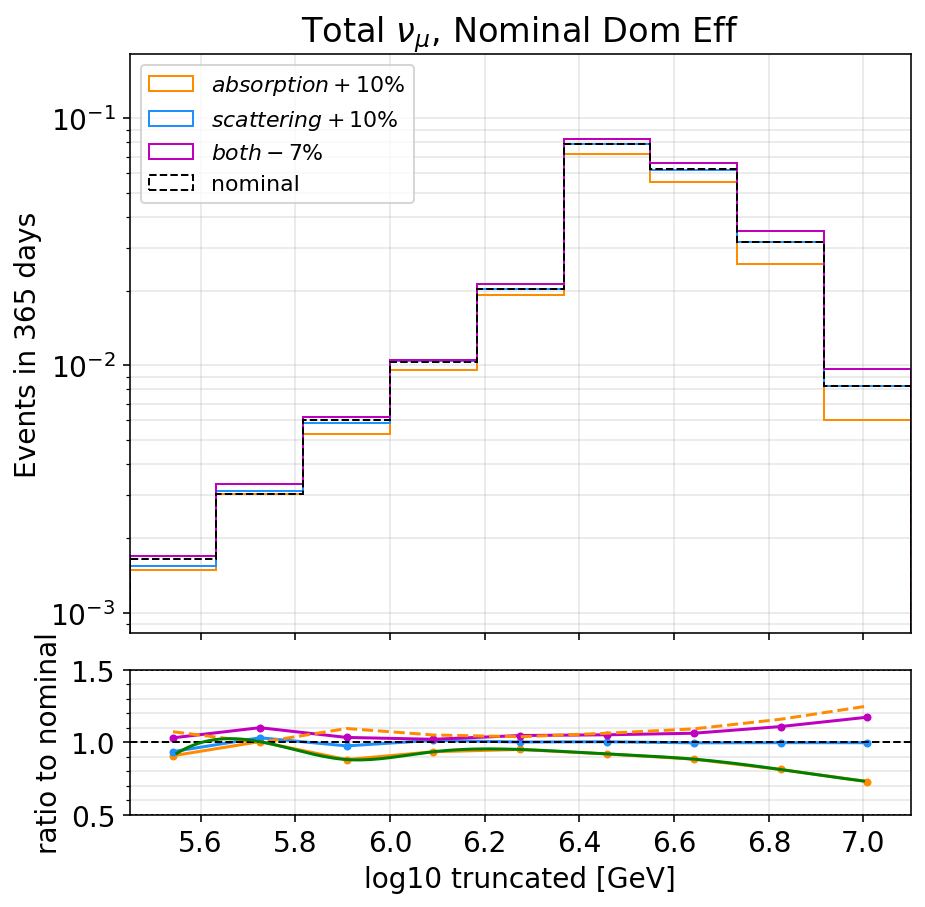

In [13]:
comparison([
            np.log10(merged_nominal_11883_energy),
            np.log10(merged_abs_DOM_nominal_11883_energy),
            np.log10(merged_scat_DOM_nominal_11883_energy),
            np.log10(merged_both_DOM_nominal_11883_energy)
           ],
           [
            merged_nominal_11883_weight,
            merged_abs_DOM_nominal_11883_weight,
            merged_scat_DOM_nominal_11883_weight,
            merged_both_DOM_nominal_11883_weight,
           ],
            np.linspace(5.45,7.1,10),
           'log10 truncated [GeV]',
           r'Total $\nu_\mu$, Nominal Dom Eff'
          )

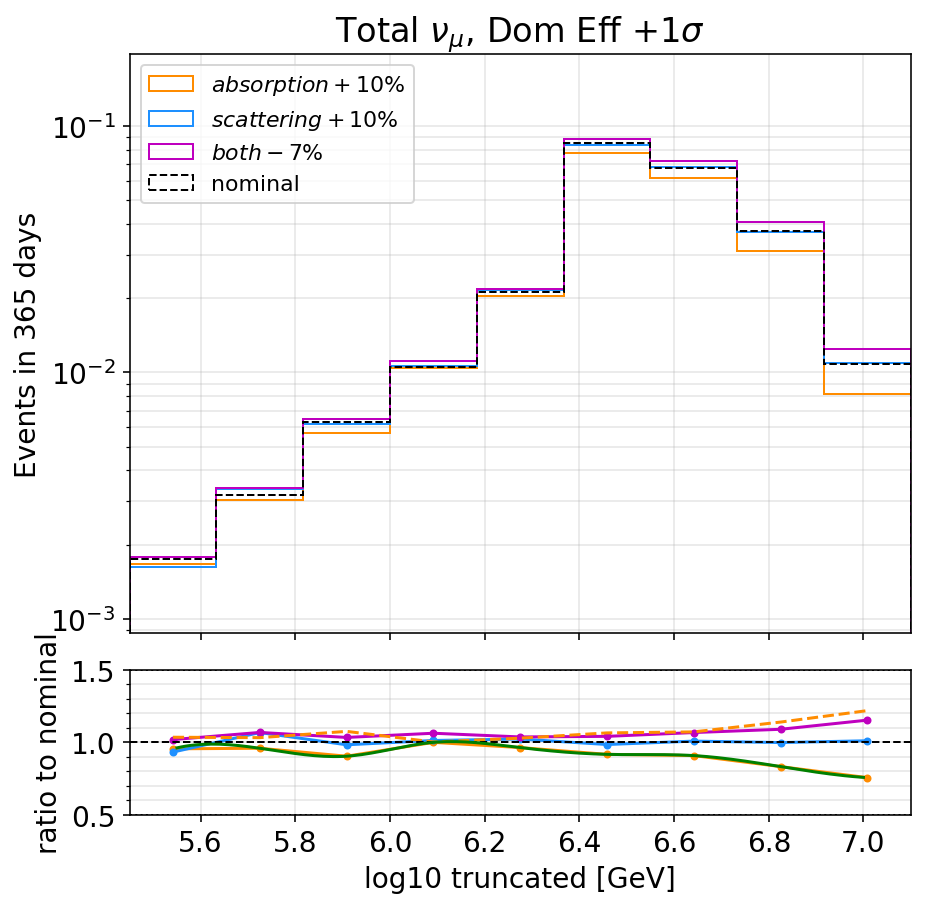

In [14]:
comparison([
            np.log10(merged_up_11883_energy),
            np.log10(merged_abs_DOM_up_11883_energy),
            np.log10(merged_scat_DOM_up_11883_energy),
            np.log10(merged_both_DOM_up_11883_energy)
           ],
           [
            merged_up_11883_weight,
            merged_abs_DOM_up_11883_weight,
            merged_scat_DOM_up_11883_weight,
            merged_both_DOM_up_11883_weight,
           ],
            np.linspace(5.45,7.1,10),
           'log10 truncated [GeV]',
           r'Total $\nu_\mu$, Dom Eff +1$\sigma$'
          )

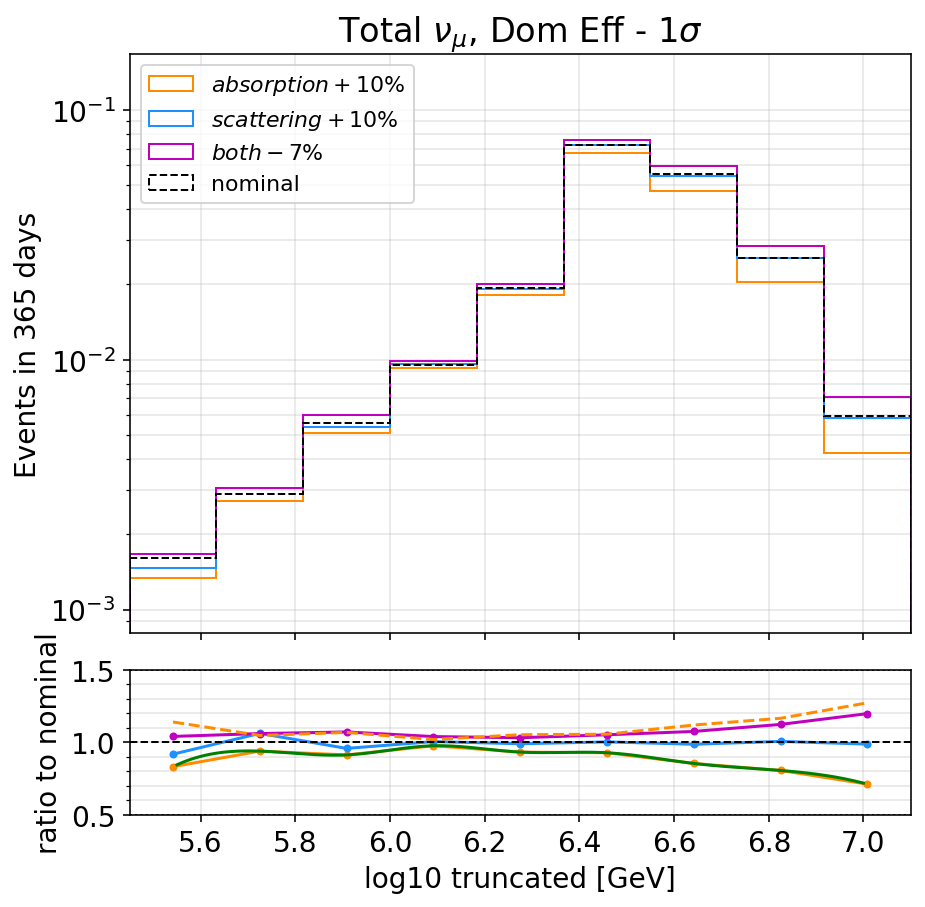

In [15]:
comparison([
            np.log10(merged_down_11883_energy),
            np.log10(merged_abs_DOM_down_11883_energy),
            np.log10(merged_scat_DOM_down_11883_energy),
            np.log10(merged_both_DOM_down_11883_energy)
           ],
           [
            merged_down_11883_weight,
            merged_abs_DOM_down_11883_weight,
            merged_scat_DOM_down_11883_weight,
            merged_both_DOM_down_11883_weight,
           ],
            np.linspace(5.45,7.1,10),
           'log10 truncated [GeV]',
           r'Total $\nu_\mu$, Dom Eff - 1$\sigma$'
          )

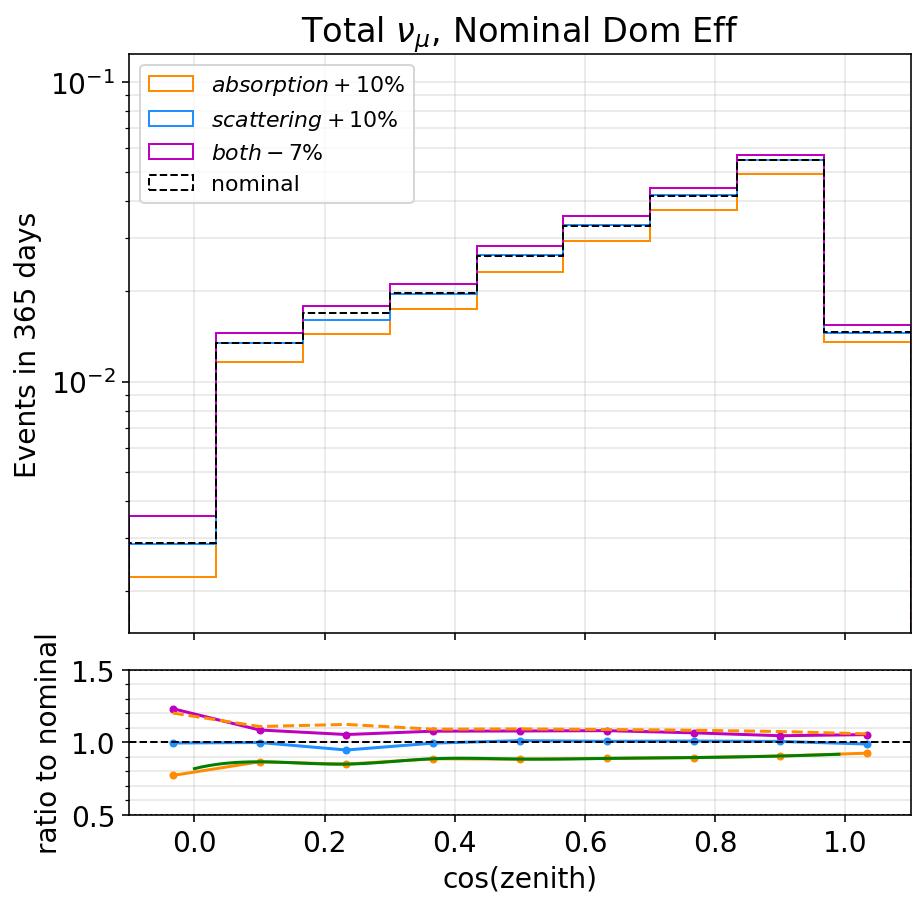

In [16]:
comparison([
            np.cos(merged_nominal_11883_zenith),
            np.cos(merged_abs_DOM_nominal_11883_zenith),
            np.cos(merged_scat_DOM_nominal_11883_zenith),
            np.cos(merged_both_DOM_nominal_11883_zenith)
           ],
           [
            merged_nominal_11883_weight,
            merged_abs_DOM_nominal_11883_weight,
            merged_scat_DOM_nominal_11883_weight,
            merged_both_DOM_nominal_11883_weight,
           ],
            np.linspace(-0.1,1.1,10),
           'cos(zenith)',
           r'Total $\nu_\mu$, Nominal Dom Eff'
          )

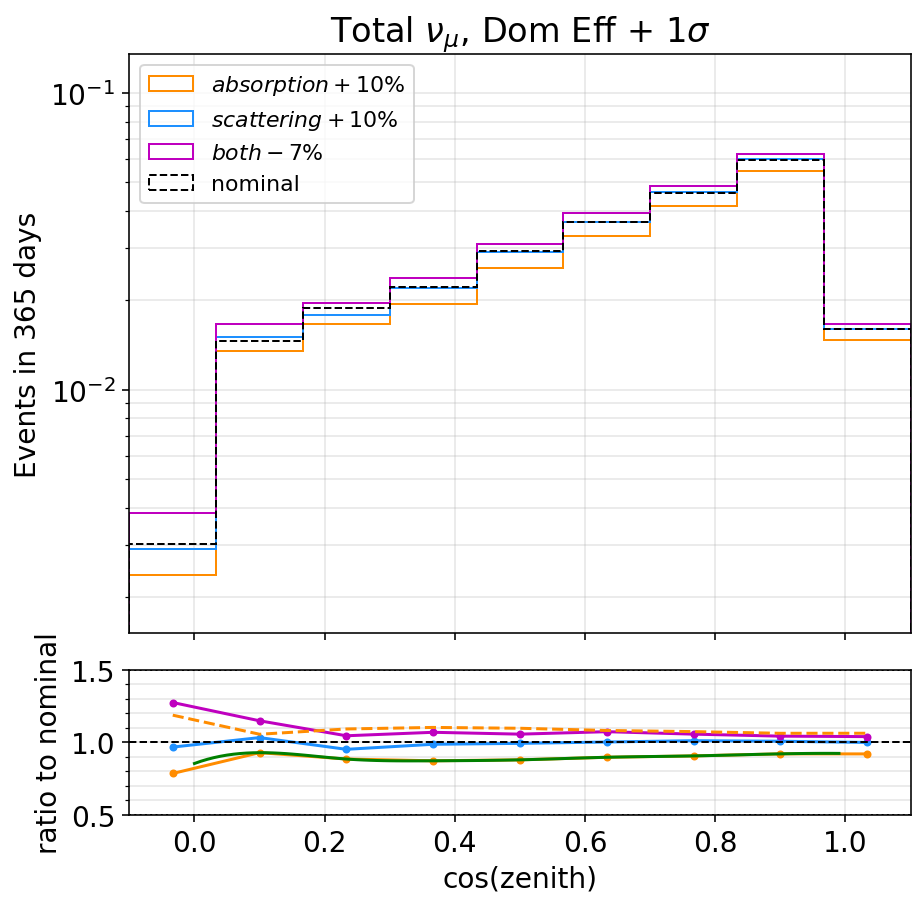

In [17]:
comparison([
            np.cos(merged_up_11883_zenith),
            np.cos(merged_abs_DOM_up_11883_zenith),
            np.cos(merged_scat_DOM_up_11883_zenith),
            np.cos(merged_both_DOM_up_11883_zenith)
           ],
           [
            merged_up_11883_weight,
            merged_abs_DOM_up_11883_weight,
            merged_scat_DOM_up_11883_weight,
            merged_both_DOM_up_11883_weight,
           ],
            np.linspace(-0.1,1.1,10),
           'cos(zenith)',
           r'Total $\nu_\mu$, Dom Eff + $1\sigma$'
          )

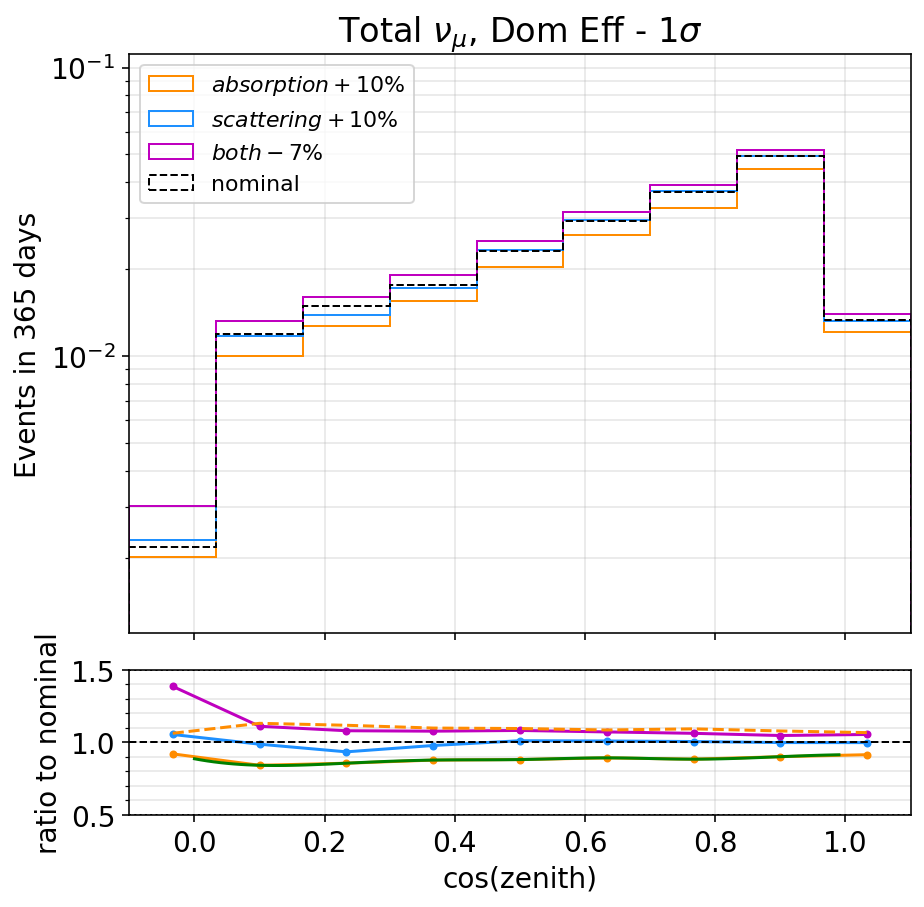

In [18]:
comparison([
            np.cos(merged_down_11883_zenith),
            np.cos(merged_abs_DOM_down_11883_zenith),
            np.cos(merged_scat_DOM_down_11883_zenith),
            np.cos(merged_both_DOM_down_11883_zenith)
           ],
           [
            merged_down_11883_weight,
            merged_abs_DOM_down_11883_weight,
            merged_scat_DOM_down_11883_weight,
            merged_both_DOM_down_11883_weight,
           ],
            np.linspace(-0.1,1.1,10),
           'cos(zenith)',
           r'Total $\nu_\mu$, Dom Eff - $1\sigma$'
          )

# parametrize surface! 

In [19]:
def center(x):
    return (x[1:] + x[:-1])/2

def sumw2(b,weight,quantity):
    w_2 = []
    for i in range(0,len(b)-1):
        all_weight_in_bin = weight[(b[i]<quantity)&(quantity<b[i+1])]
        w_2.append(np.sum(all_weight_in_bin**2))
    return w_2

def uncert(x,y,sig_x,sig_y):
    x = np.array(x)
    y = np.array(y)
    sig_x = np.array(sig_x)
    sig_y = np.array(sig_y)
    return x/y * np.sqrt(1/x**2 * sig_x**2 + 1/y**2 * sig_y**2)

def boot_idx(weight):
    idx = np.arange(len(weight))
    choices = np.random.choice(idx,len(idx),replace=True)
    return choices

def comparison(var,weight,bins,varname,title):
    var_nominal = var[0]
    var_abs = var[1]
    var_scat = var[2]
    var_both = var[3]

    weight_nominal = weight[0]
    weight_abs = weight[1]
    weight_scat = weight[2]
    weight_both = weight[3]

    plt.figure(figsize=(7,7))

    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
    c_abs = 'darkorange'
    c_scat = 'dodgerblue'
    c_both = 'm'
#     if 'cos' in varname:
#         c_abs = 'tomato'
#         c_scat = 'darkturquoise'
#         c_both = 'r'
    h_abs,b_abs,_ = plt.hist(var_abs,bins=bins,log=True,weights=weight_abs,histtype='step',label=r'$absorption+10\%$',bottom=10**(-8),color=c_abs)
    h_scat,b_scat,_ = plt.hist(var_scat,bins=bins,log=True,weights=weight_scat,histtype='step',label=r'$scattering+10\%$',bottom=10**(-8),color=c_scat)
    h_both,b_both,_ = plt.hist(var_both,bins=bins,log=True,weights=weight_both,histtype='step',label=r'$both-7\%$',bottom=10**(-8),color=c_both)
    h_nominal,b_nominal,_ = plt.hist(var_nominal,bins=bins,log=True,weights=weight_nominal,histtype='step',linestyle='dashed',label=r'nominal',bottom=10**(-8),color='black')

    plt.ylabel('Events in 365 days')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(np.min(h_nominal)/2,)
    plt.legend(prop={'size': 11},loc='upper left')
    plt.title(title)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    
    
    ax2 = plt.subplot(gs[1])
    
    # remove empty bins
    b = (b_nominal[1:] + b_nominal[:-1])/2
    cut_nozero = (h_nominal>0)
    b = b[cut_nozero]
    h_abs = h_abs[cut_nozero]
    h_scat = h_scat[cut_nozero]
    h_nominal = h_nominal[cut_nozero]
    
    plt.plot(b, h_abs/h_nominal, '.-',color=c_abs)
    plt.plot(b, h_scat/h_nominal, '.-',color=c_scat)
    plt.plot(b, h_both/h_nominal, '.-',color=c_both)
    
    f_scaling = (h_abs/h_nominal)
#     plt.plot(b, f_scaling**(10*(0.93-1.0)), '--',color=c_abs)

    
    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')

    plt.xlabel(varname)
    plt.ylabel('ratio to nominal')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(0.5,1.5)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
    # do spline 
    inter = ci.interpolate.interp1d(b, f_scaling, kind='cubic',bounds_error=False,fill_value='extrapolate')
    t = np.arange(np.min(bins)+0.1,np.max(bins)-0.1,0.01)
    plt.plot(t, inter(t),label='spline',color='green')
    
    return inter # 1d interpolation for scaling factor

def surf(best_norm, interp_var, x_coord, y_coord):
    mat = np.zeros((len(x_coord),len(y_coord)))
    for i in range(0,len(x_coord)): # zenith
        for j in range(0,len(y_coord)): # energy
#             mat[j,i] = best_norm * interp_zenith(x_coord[i]) * interp_energy(y_coord[j])
            mat[j,i] = best_norm * interp_var(y_coord[j]) # assume constant zenith effect
    return mat

def parametrize(zenith,energy,weight,bins,varname,title):
    
    # first, make some plots. 
    interp_energy = comparison(energy,weight,bins[1],varname[1],title)
    interp_zenith = comparison(zenith,weight,bins[0],varname[0],title)
    
    zenith_nominal = zenith[0]
    zenith_abs = zenith[1]
    zenith_scat = zenith[2]
    zenith_both = zenith[3]
    
    energy_nominal = energy[0]
    energy_abs = energy[1]
    energy_scat = energy[2]
    energy_both = energy[3]
    
    weight_nominal = weight[0]
    weight_abs = weight[1]
    weight_scat = weight[2]
    weight_both = weight[3]

    bin_x = bins[0]
    bin_y = bins[1]
    
    x_coord = center(bin_x)
    y_coord = center(bin_y)

    # try shuffle datapoints in 2d
    nominals = []
    abss = []
    scats = []
    boths = []
    for i in range(0,50):
        idx_nominal = boot_idx(weight_nominal)
        idx_abs = boot_idx(weight_abs)
        idx_scat = boot_idx(weight_scat)
        idx_both = boot_idx(weight_both)
        
        h_nominal,_,_=np.histogram2d(zenith_nominal[idx_nominal], 
                                      energy_nominal[idx_nominal],
                                      weights=weight_nominal[idx_nominal],
                                      bins = (np.linspace(0,1,11),np.linspace(5.5,7,11)),
                                     )
        h_abs,_,_=np.histogram2d(zenith_abs[idx_abs], 
                                      energy_abs[idx_abs],
                                      weights=weight_abs[idx_abs],
                                      bins = (np.linspace(0,1,11),np.linspace(5.5,7,11)),
                                     )
        h_scat,_,_=np.histogram2d(zenith_scat[idx_scat], 
                                      energy_scat[idx_scat],
                                      weights=weight_scat[idx_scat],
                                      bins = (np.linspace(0,1,11),np.linspace(5.5,7,11)),
                                     )
        h_both,_,_=np.histogram2d(zenith_both[idx_both], 
                                      energy_both[idx_both],
                                      weights=weight_both[idx_both],
                                      bins = (np.linspace(0,1,11),np.linspace(5.5,7,11)),
                                     )
        nominals.append(h_nominal)
        abss.append(h_abs)
        scats.append(h_scat)
        boths.append(h_both)
        
    nominal = np.mean(nominals,axis=0).T
    abs = np.mean(abss,axis=0).T
    scat = np.mean(scats,axis=0).T
    both = np.mean(boths,axis=0).T

    abs_ratio = abs/nominal
    scat_ratio = scat/nominal
    both_ratio = both/nominal
    f_scaling_2d = abs_ratio

    # plot 2d distributions
    if 'Conv' in title or 'Prompt' in title:
        clower = 0.5
        cupper = 1.5
    else:
        clower = 0.5
        cupper = 1.5
    plt.figure()
    plt.pcolormesh(bin_x,bin_y,abs_ratio,cmap='coolwarm')
    plt.colorbar()
    plt.clim(clower, cupper)
    plt.xlabel('cos(zenith)')
    plt.ylabel('log10 truncated')
    plt.title('Smoothened absorption/nominal')

    plt.figure()
    plt.pcolormesh(bin_x,bin_y,scat_ratio,cmap='coolwarm')
    plt.colorbar()
    plt.clim(clower, cupper)
    plt.xlabel('cos(zenith)')
    plt.ylabel('log10 truncated')
    plt.title('Smoothened scattering/nominal')
    plt.show()
    
    plt.figure()
    plt.pcolormesh(bin_x,bin_y,both_ratio,cmap='coolwarm')
    plt.colorbar()
    plt.clim(clower, cupper)
    plt.xlabel('cos(zenith)')
    plt.ylabel('log10 truncated')
    plt.title('Smoothened both/nominal')
    plt.show()

    plt.figure()
    plt.pcolormesh(bin_x,bin_y,f_scaling_2d,cmap='coolwarm')
    plt.colorbar()
    plt.clim(clower, cupper)
    plt.xlabel('cos(zenith)')
    plt.ylabel('log10 truncated')
    plt.title('Smoothened scaling factor')
    plt.show()
    
    def Loss(N, interp_var, f_scaling_2d):
        tmp = []
        for i in range(0,len(x_coord)): # zenith
            for j in range(0,len(y_coord)): # energy

    #             pred = N * interp_zenith(x_coord[i]) * interp_var(y_coord[j])
                pred = N * interp_var(y_coord[j]) # assume constant zenith effect
                obs = f_scaling_2d[j][i]
                
                if (~np.isnan(pred) and ~np.isnan(obs) and obs!=0):
                    term = (obs-pred)**2/obs
                    tmp.append(term)

        return np.sum(tmp)
    
    ns = np.arange(0.2,1.5,0.01)
    ls = []
    for i in ns:
        ls.append(Loss(i, interp_energy, f_scaling_2d))
    best_norm = ns[np.argmin(ls)]
    plt.plot(ns,ls)
    plt.axvline(ns[np.argmin(ls)],color='green',label='min='+str(np.round(ns[np.argmin(ls)],3)))
    plt.legend()
    plt.xlabel('normalization')
    plt.ylabel('L2 loss')
    plt.show()
    
    tx = np.linspace(0.02,1,50)
    ty = np.linspace(5.6,7,50)
    interp_surface = surf(best_norm, interp_energy, tx, ty)

    plt.figure()
    plt.pcolormesh(tx,ty,interp_surface,cmap='coolwarm')
    plt.colorbar()
    plt.clim(clower, cupper)
    plt.xlabel('cos(zenith)')
    plt.ylabel('log10 truncated')
    plt.title('Interpolated scaling factor, '+title)
    plt.show()
    
    return interp_energy, best_norm

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


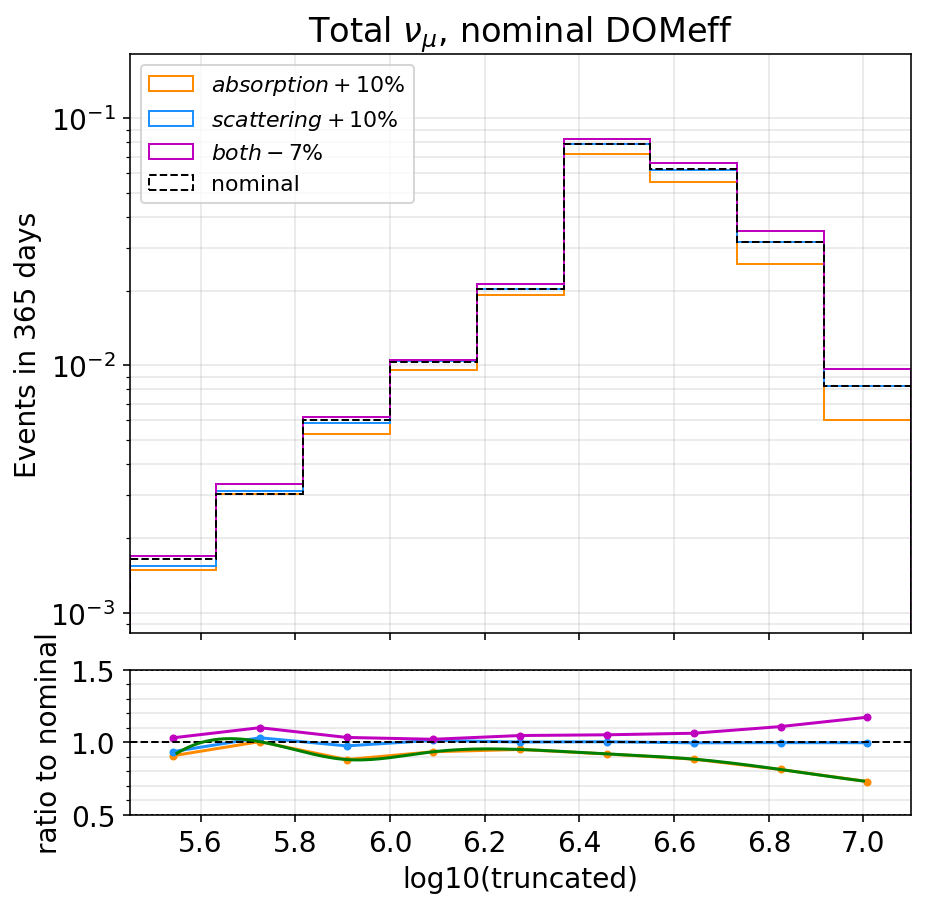

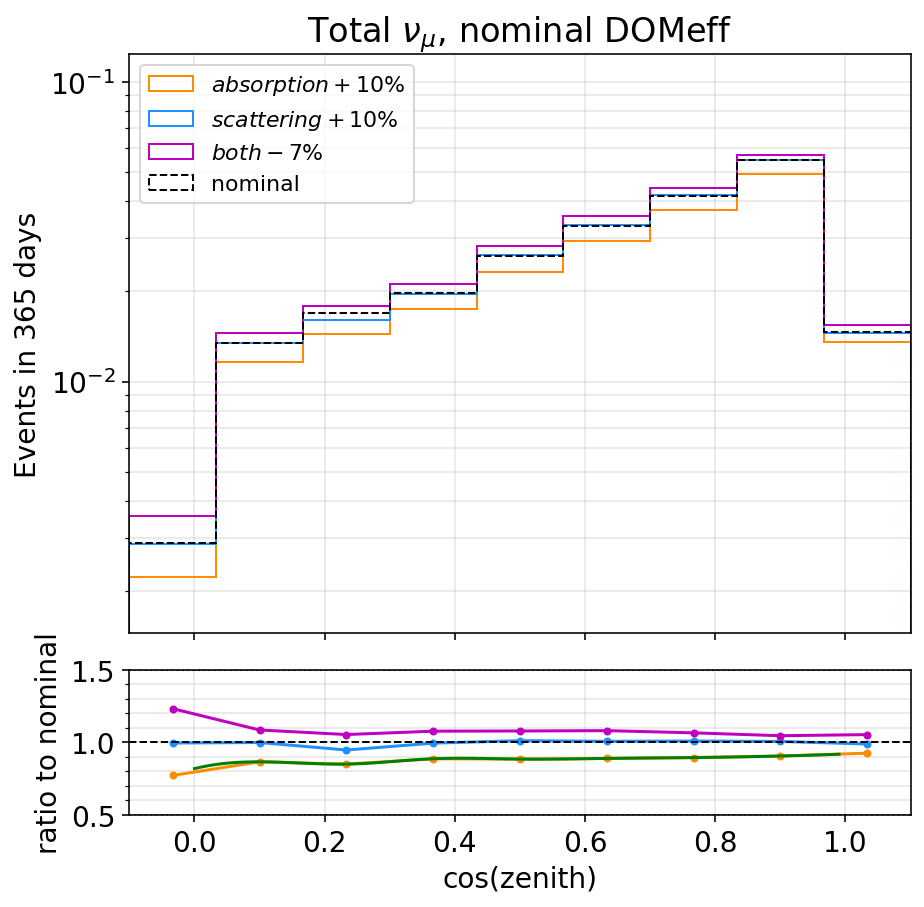

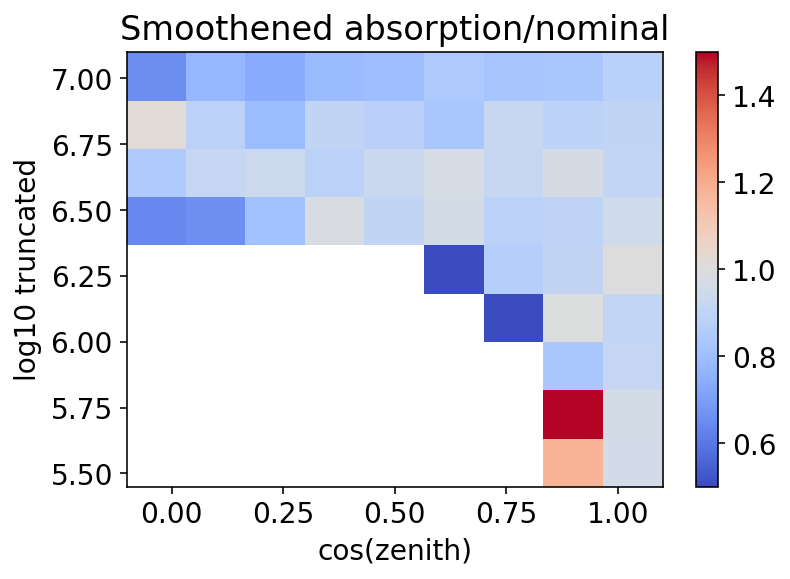

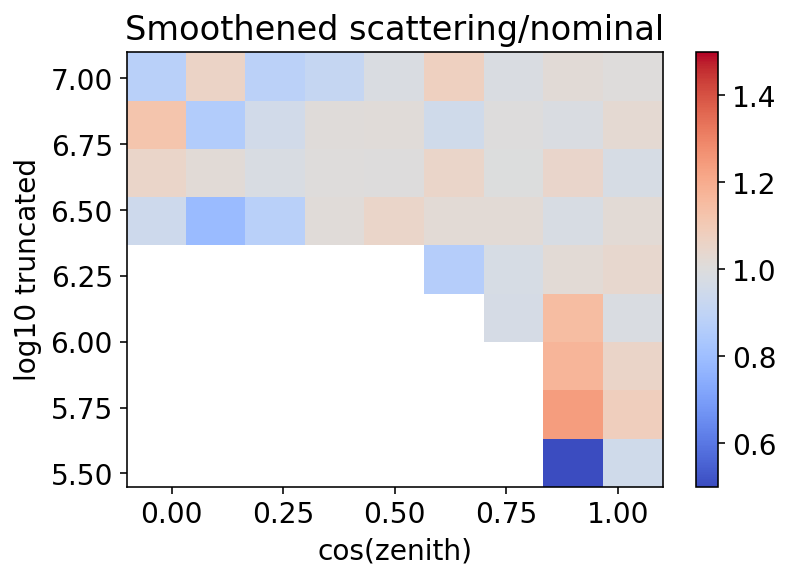

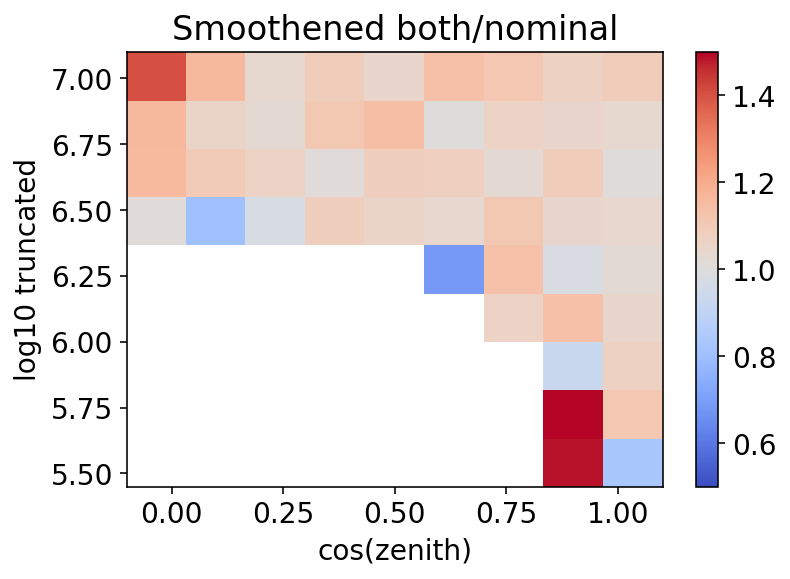

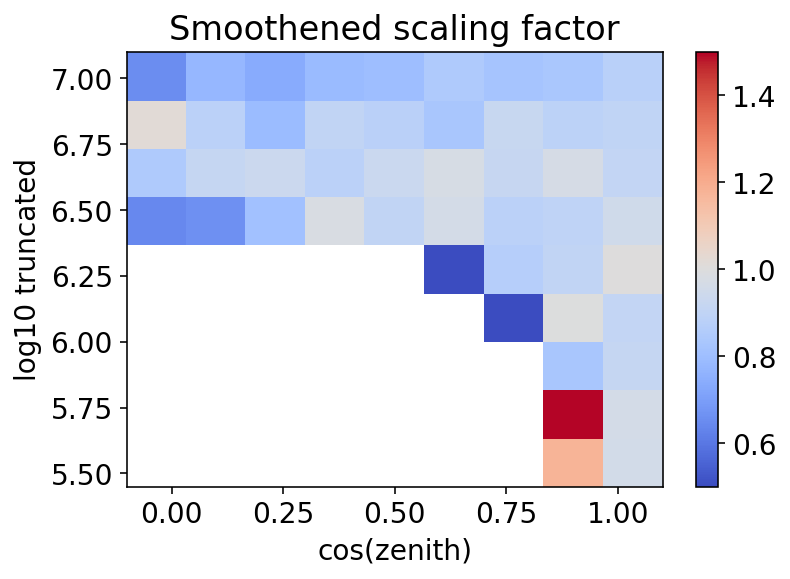

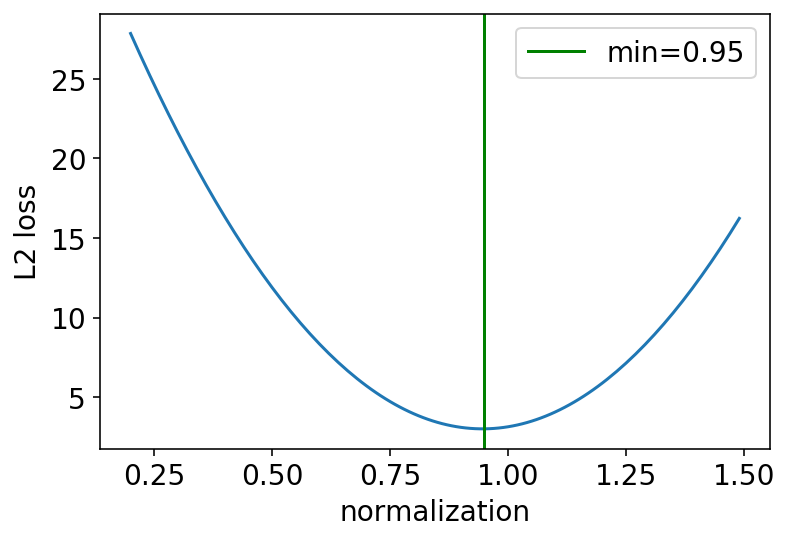

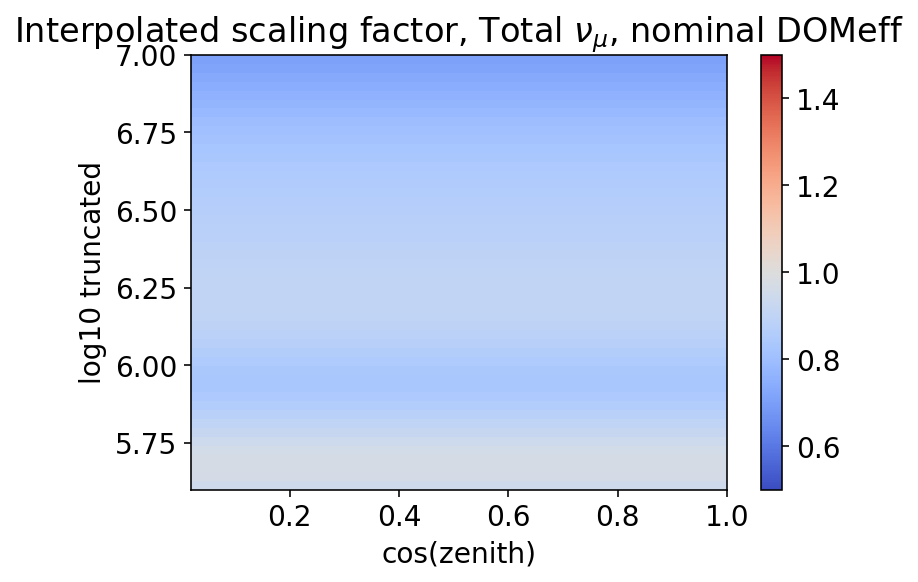

In [20]:
interp_energy_dom_nominal, best_norm_dom_nominal = parametrize([np.cos(merged_nominal_11883_zenith),
            np.cos(merged_abs_DOM_nominal_11883_zenith),
            np.cos(merged_scat_DOM_nominal_11883_zenith),
            np.cos(merged_both_DOM_nominal_11883_zenith),

           ],
           [np.log10(merged_nominal_11883_energy),
            np.log10(merged_abs_DOM_nominal_11883_energy),
            np.log10(merged_scat_DOM_nominal_11883_energy),
            np.log10(merged_both_DOM_nominal_11883_energy),
           ],
           [merged_nominal_11883_weight,
            merged_abs_DOM_nominal_11883_weight,
            merged_scat_DOM_nominal_11883_weight,
            merged_both_DOM_nominal_11883_weight,
           ],
            [np.linspace(-0.1,1.1,10),
            np.linspace(5.45,7.1,10)
            ],
           ['cos(zenith)', 
            'log10(truncated)',
           ],
           r'Total $\nu_\mu$, nominal DOMeff'
          )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in true_divide


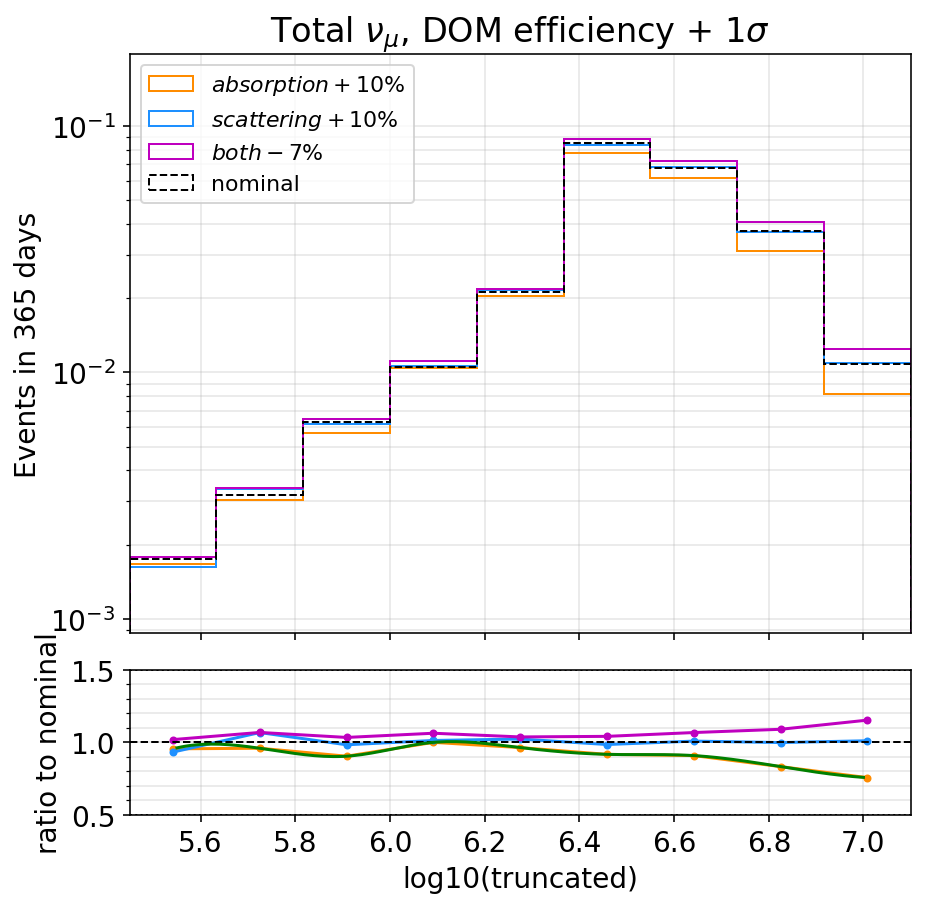

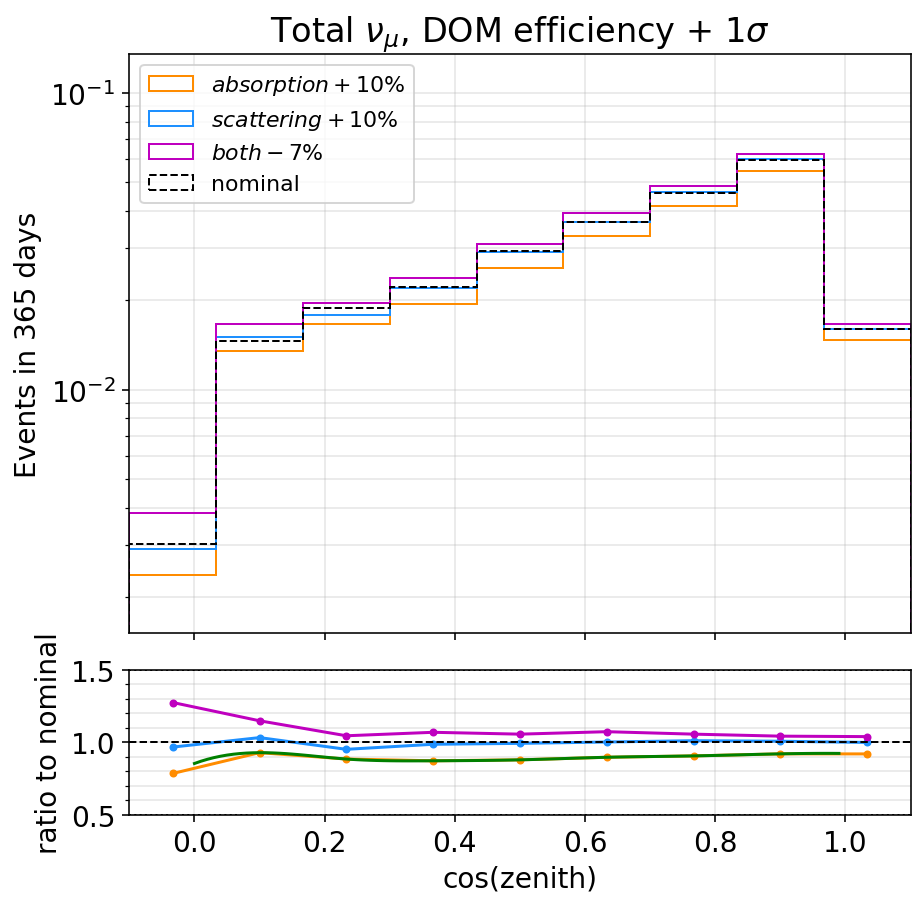

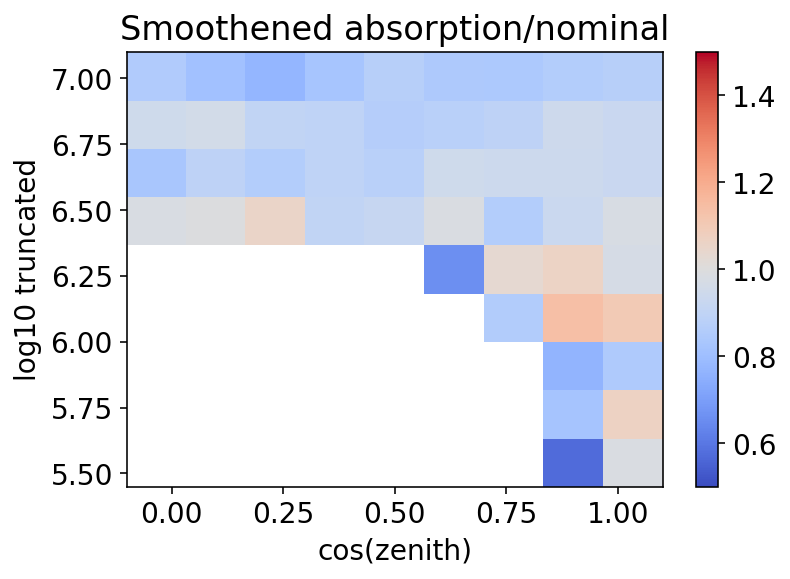

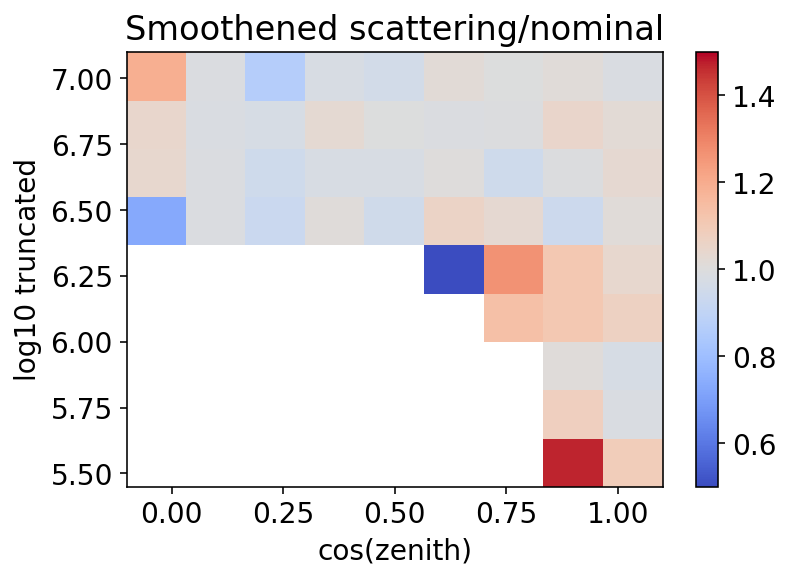

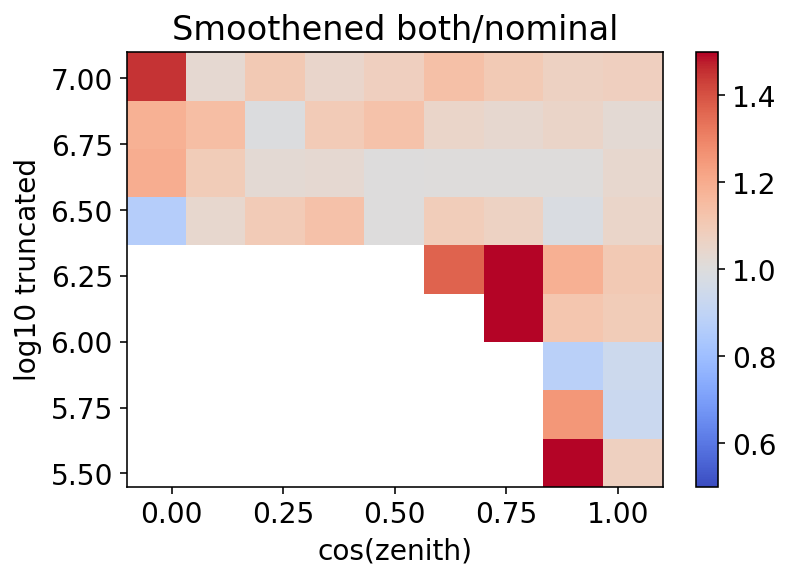

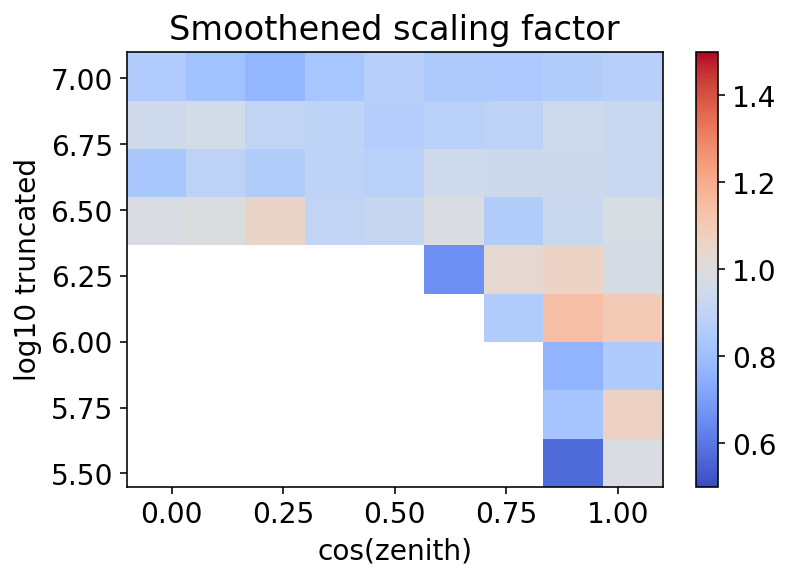

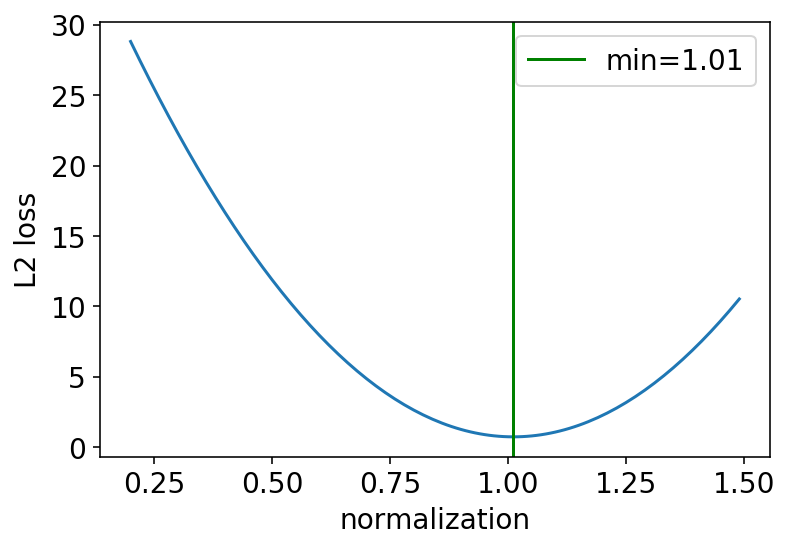

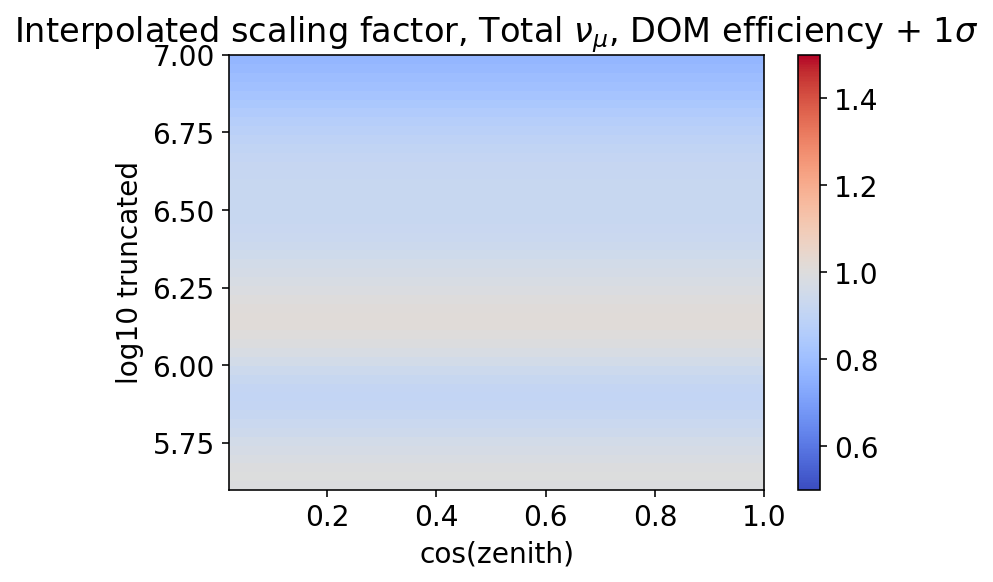

In [21]:
interp_energy_dom_up, best_norm_dom_up = parametrize([np.cos(merged_up_11883_zenith),
            np.cos(merged_abs_DOM_up_11883_zenith),
            np.cos(merged_scat_DOM_up_11883_zenith),
            np.cos(merged_both_DOM_up_11883_zenith),

           ],
           [np.log10(merged_up_11883_energy),
            np.log10(merged_abs_DOM_up_11883_energy),
            np.log10(merged_scat_DOM_up_11883_energy),
            np.log10(merged_both_DOM_up_11883_energy),
           ],
           [merged_up_11883_weight,
            merged_abs_DOM_up_11883_weight,
            merged_scat_DOM_up_11883_weight,
            merged_both_DOM_up_11883_weight,
           ],
            [np.linspace(-0.1,1.1,10),
            np.linspace(5.45,7.1,10)
            ],
           ['cos(zenith)', 
            'log10(truncated)',
           ],
           r'Total $\nu_\mu$, DOM efficiency + $1\sigma$'
          )

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide


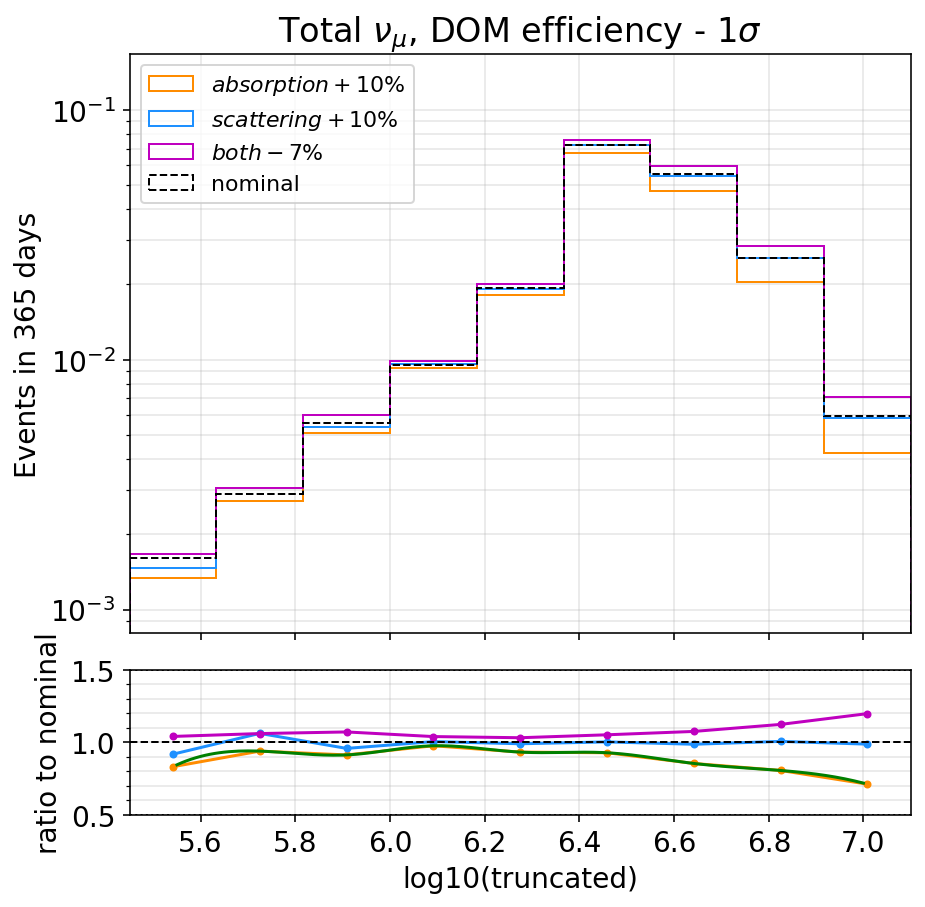

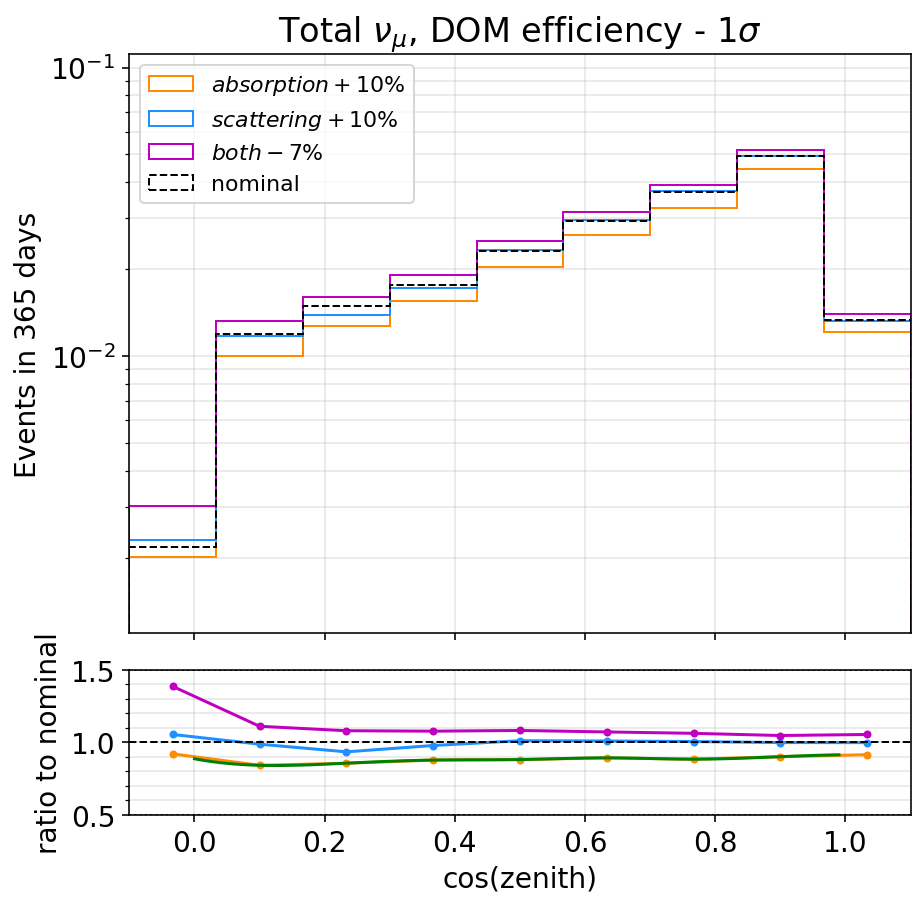

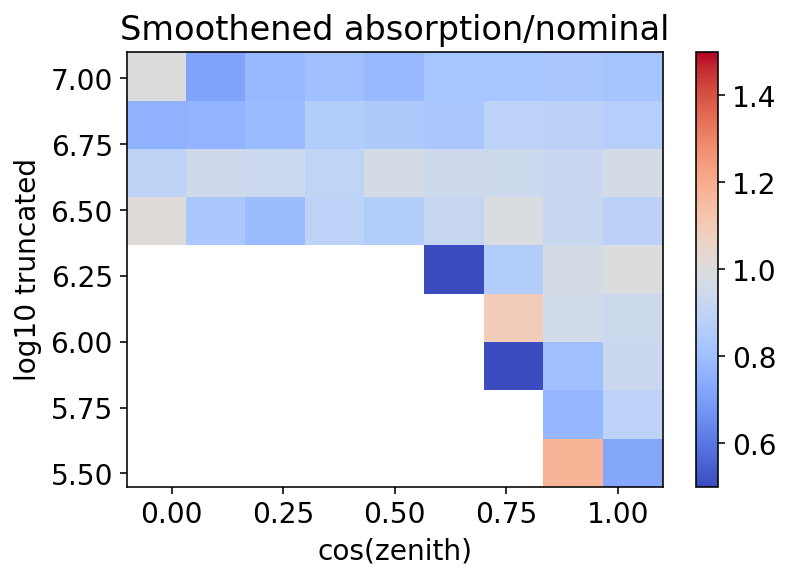

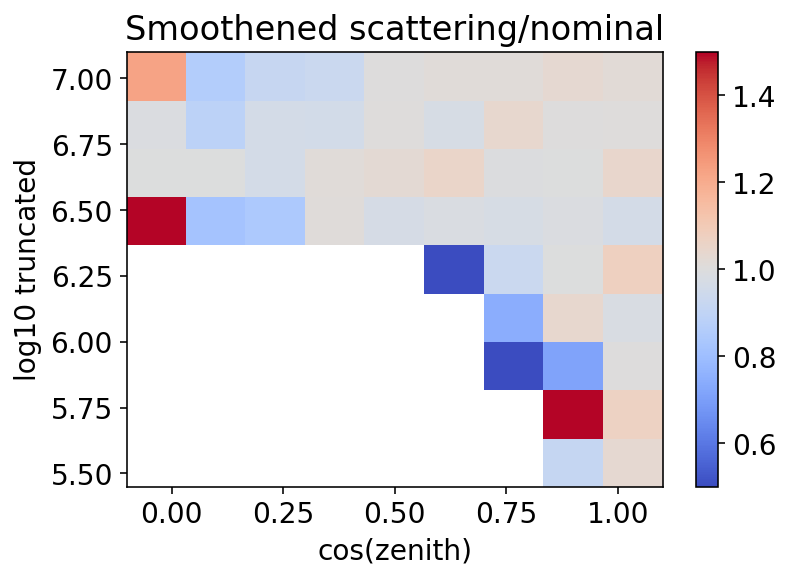

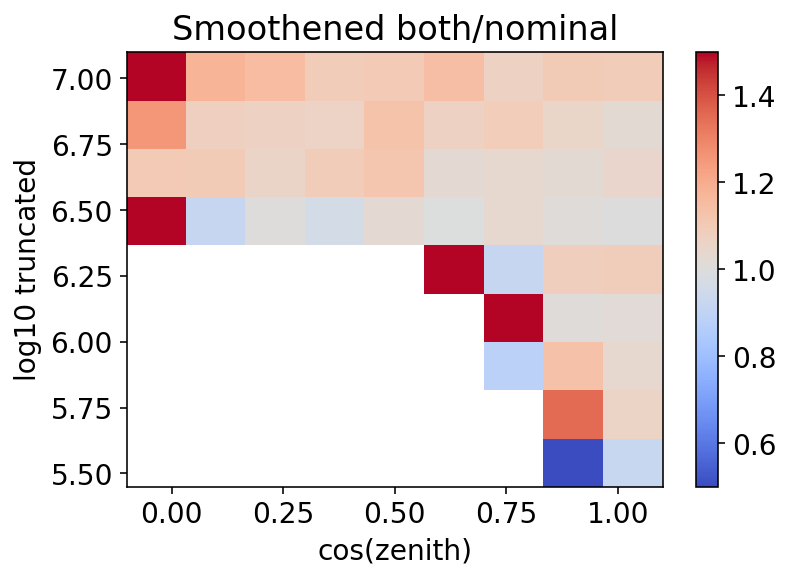

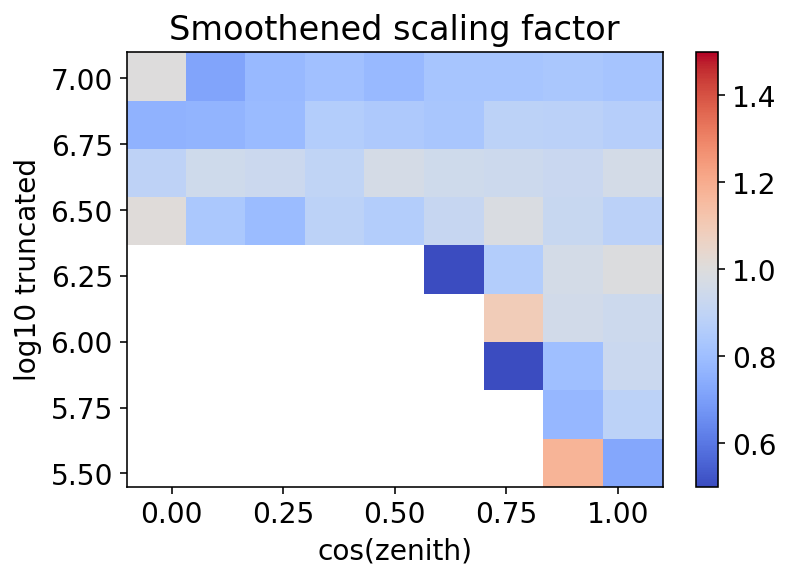

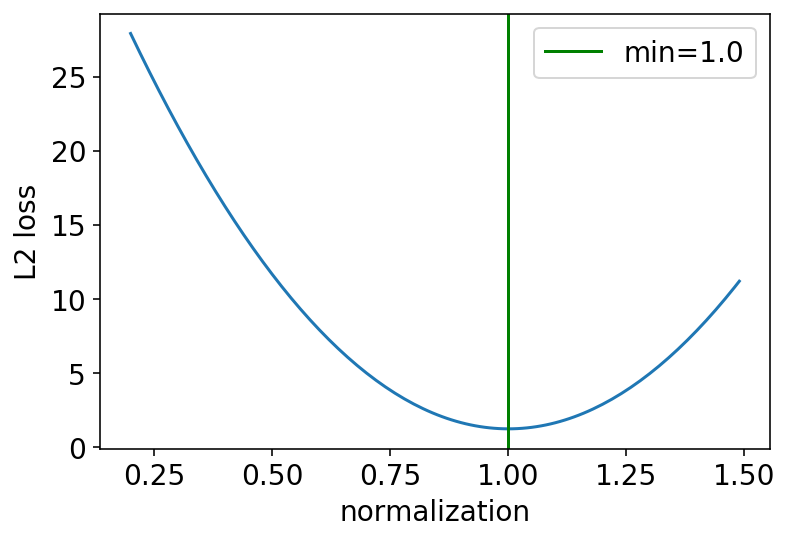

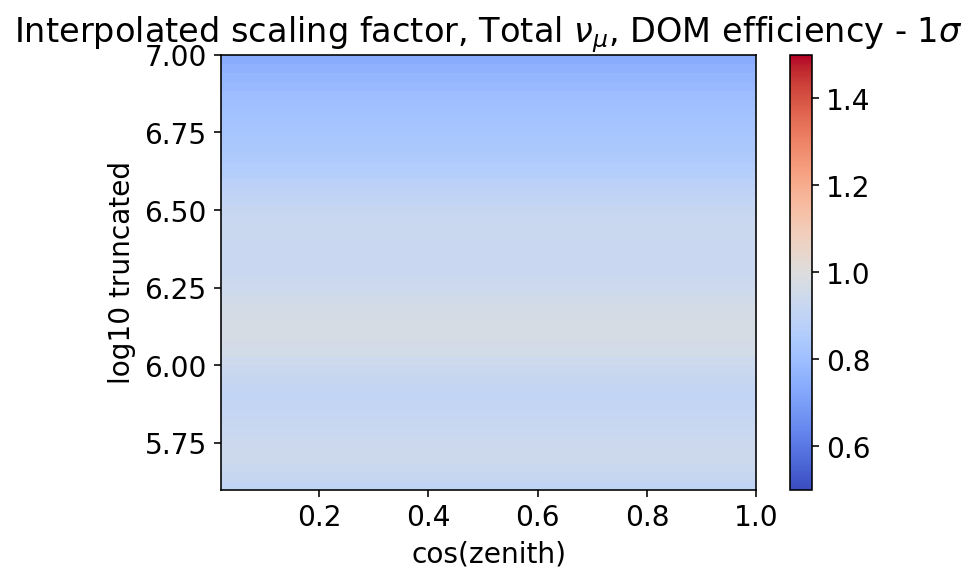

In [22]:
interp_energy_dom_down, best_norm_dom_down = parametrize([np.cos(merged_down_11883_zenith),
            np.cos(merged_abs_DOM_down_11883_zenith),
            np.cos(merged_scat_DOM_down_11883_zenith),
            np.cos(merged_both_DOM_down_11883_zenith),

           ],
           [np.log10(merged_down_11883_energy),
            np.log10(merged_abs_DOM_down_11883_energy),
            np.log10(merged_scat_DOM_down_11883_energy),
            np.log10(merged_both_DOM_down_11883_energy),
           ],
           [merged_down_11883_weight,
            merged_abs_DOM_down_11883_weight,
            merged_scat_DOM_down_11883_weight,
            merged_both_DOM_down_11883_weight,
           ],
            [np.linspace(-0.1,1.1,10),
            np.linspace(5.45,7.1,10)
            ],
           ['cos(zenith)', 
            'log10(truncated)',
           ],
           r'Total $\nu_\mu$, DOM efficiency - $1\sigma$'
          )

# average over dom eff

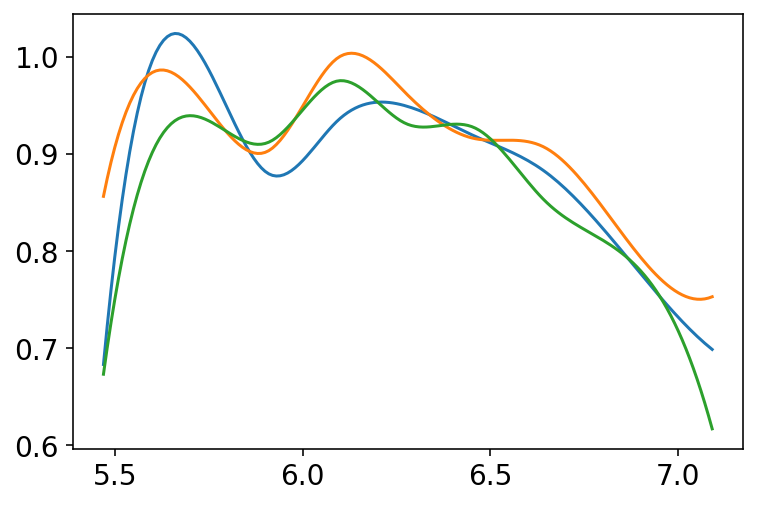

In [31]:
t = np.arange(5.47,7.1,0.01)
plt.plot(t, interp_energy_dom_nominal(t))
plt.plot(t, interp_energy_dom_up(t))
plt.plot(t, interp_energy_dom_down(t))

In [23]:
tx = np.linspace(0.02,1,50)
ty = np.linspace(5.6,7,50)
mat = np.zeros((len(tx),len(ty)))
for i in range(0,len(tx)): # zenith
    for j in range(0,len(ty)): # energy
        mat[j,i] = best_norm_dom_nominal * interp_energy_dom_nominal(ty[j]) + \
                    best_norm_dom_up * interp_energy_dom_up(ty[j]) +\
                    best_norm_dom_down * interp_energy_dom_down(ty[j]) 

mat /= 3.0

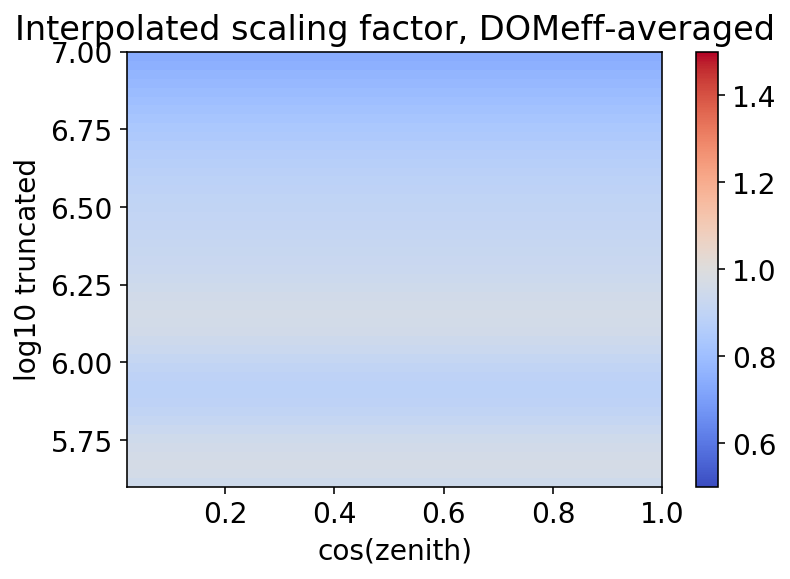

In [24]:
plt.figure()
plt.pcolormesh(tx,ty,mat,cmap='coolwarm')
plt.colorbar()
plt.clim(0.5, 1.5)
plt.xlabel('cos(zenith)')
plt.ylabel('log10 truncated')
plt.title('Interpolated scaling factor, DOMeff-averaged')
plt.show()

# save event weight 

In [25]:
spline_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/splines/myown_syst/'
with open(spline_dir + 'absorption_spline_dom_nominal.pkl', 'wb') as output:
    pickle.dump(interp_energy_dom_nominal, output)
with open(spline_dir + 'absorption_spline_dom_up.pkl', 'wb') as output:
    pickle.dump(interp_energy_dom_up, output)
with open(spline_dir + 'absorption_spline_dom_down.pkl', 'wb') as output:
    pickle.dump(interp_energy_dom_down, output)
    
np.save(spline_dir + 'absorption_best_norms.npy', [best_norm_dom_nominal, best_norm_dom_up, best_norm_dom_down])

In [26]:
# best_norm_dom_nominal * interp_energy_dom_nominal(ty[j]) + \
#                     best_norm_dom_up * interp_energy_dom_up(ty[j]) +\
#                     best_norm_dom_down * interp_energy_dom_down(ty[j]) 
# class absorption:
#     def __init__(self, nom, up, down, interpnom, interpup, interpdown):
#         self.best_norm_dom_nominal = nom
#         self.best_norm_dom_up = up
#         self.best_norm_dom_down = down
#         self.interp_energy_dom_nominal = interpnom
#         self.interp_energy_dom_up = interp_energy_dom_up
#         self.interp_energy_dom_down = interp_energy_dom_down
#     def interp(self, E):
#         scale = self.best_norm_dom_nominal * self.interp_energy_dom_nominal(E) + \
#                     self.best_norm_dom_up * self.interp_energy_dom_up(E) +\
#                     self.best_norm_dom_down * self.interp_energy_dom_down(E) 
#         scale *= 1/3.0
#         return scale

In [27]:
# tosave = absorption(best_norm_dom_nominal,
#                best_norm_dom_up,
#                best_norm_dom_down,
#                interp_energy_dom_nominal,
#                interp_energy_dom_up,
#                interp_energy_dom_down)

In [28]:
# with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/HESE_data_release/HESE_data_release/resources/splines/myown_syst/absorption_scaling.pkl', 'wb') as output:
#     pickle.dump(tosave, output)#, pickle.HIGHEST_PROTOCOL)

# check distribution for different abs, scat settings

In [29]:
def comparison(var,weight,bins,varname,title):
    var_nominal = var[0]
    var_abs = var[1]
    var_scat = var[2]
    var_both = var[3]

    weight_nominal = weight[0]
    weight_abs = weight[1]
    weight_scat = weight[2]
    weight_both = weight[3]

    plt.figure(figsize=(7,7))

    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], wspace=0.0, hspace=0.1)
    ax1 = plt.subplot(gs[0])
    
    c_abs = 'darkorange'
    c_scat = 'dodgerblue'
    c_both = 'm'
#     if 'cos' in varname:
#         c_abs = 'tomato'
#         c_scat = 'darkturquoise'
#         c_both = 'r'
    h_abs,b_abs,_ = plt.hist(var_abs,bins=bins,log=True,weights=weight_abs,histtype='step',label=r'$absorption$',bottom=10**(-8),color=c_abs)
    h_scat,b_scat,_ = plt.hist(var_scat,bins=bins,log=True,weights=weight_scat,histtype='step',label=r'$scattering$',bottom=10**(-8),color=c_scat)
    h_both,b_both,_ = plt.hist(var_both,bins=bins,log=True,weights=weight_both,histtype='step',label=r'$both$',bottom=10**(-8),color=c_both)
    h_nominal,b_nominal,_ = plt.hist(var_nominal,bins=bins,log=True,weights=weight_nominal,histtype='step',linestyle='dashed',label=r'nominal',bottom=10**(-8),color='black')

    plt.ylabel('Events in 365 days')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(np.min(h_nominal)/2,)
    plt.legend(prop={'size': 11},loc='best')
    plt.title(title)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax1.tick_params(labelbottom=False)    
    
    ax2 = plt.subplot(gs[1])
    
    # remove empty bins
    b = (b_nominal[1:] + b_nominal[:-1])/2
    cut_nozero = (h_nominal>0)
    
    plt.plot(b[cut_nozero], h_abs[cut_nozero]/h_nominal[cut_nozero], '.-',color=c_abs)
    plt.plot(b[cut_nozero], h_scat[cut_nozero]/h_nominal[cut_nozero], '.-',color=c_scat)
    plt.plot(b[cut_nozero], h_both[cut_nozero]/h_nominal[cut_nozero], '.-',color=c_both)

    plt.axhline(1,ls='--',lw=1,color='black')
    plt.axhline(0.5,ls=':',lw=1,color='black')
    plt.axhline(1.5,ls=':',lw=1,color='black')

    plt.xlabel(varname)
    plt.ylabel('ratio to nominal')
    plt.xlim(np.min(bins),np.max(bins))
    plt.ylim(0.5,1.5)
    plt.grid(True,which='both',zorder=0,alpha=0.3)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    
#     plt.savefig(fig_dir+varname+'_dataMC.png',dpi=300)

### astro numu

In [30]:
comparison([
            np.log10(prim_e_numu_domeff_nominal),
            np.log10(prim_e_numu_abs_nominal),
            np.log10(prim_e_numu_scat_nominal),
            np.log10(prim_e_numu_abs_scat_nominal)
           ],
           [
            weight_astro_numu_domeff_nominal,
            weight_astro_numu_abs_nominal,
            weight_astro_numu_scat_nominal,
            weight_astro_numu_abs_scat_nominal,
           ],
           np.linspace(5.,7.,11),
           'log10 primary E [GeV]',
           r'Astro $\nu_\mu$, Nominal Dom Eff'
          )

NameError: name 'prim_e_numu_domeff_nominal' is not defined

In [ ]:
comparison([
            np.log10(truncated_muon_e_numu_domeff_nominal),
            np.log10(truncated_muon_e_numu_abs_nominal),
            np.log10(truncated_muon_e_numu_scat_nominal),
            np.log10(truncated_muon_e_numu_abs_scat_nominal)
           ],
           [
            weight_astro_numu_domeff_nominal,
            weight_astro_numu_abs_nominal,
            weight_astro_numu_scat_nominal,
            weight_astro_numu_abs_scat_nominal,
           ],
           np.linspace(5.5,8.,11),
           'log10 truncated [GeV]',
           r'Astro $\nu_\mu$, Nominal Dom Eff'
          )

In [ ]:
comparison([
            np.cos(zenith_numu_domeff_nominal),
            np.cos(zenith_numu_abs_nominal),
            np.cos(zenith_numu_scat_nominal),
            np.cos(zenith_numu_abs_scat_nominal)
           ],
           [
            weight_astro_numu_domeff_nominal,
            weight_astro_numu_abs_nominal,
            weight_astro_numu_scat_nominal,
            weight_astro_numu_abs_scat_nominal,
           ],
           np.linspace(0,1,11),
           'cos(zenith)',
           r'Astro $\nu_\mu$, Nominal Dom Eff'
          )

In [ ]:
comparison([
            np.log10(truncated_muon_e_numu_domeff_up),
            np.log10(truncated_muon_e_numu_abs_up),
            np.log10(truncated_muon_e_numu_scat_up),
            np.log10(truncated_muon_e_numu_abs_scat_up)
           ],
           [
            weight_astro_numu_domeff_up,
            weight_astro_numu_abs_up,
            weight_astro_numu_scat_up,
            weight_astro_numu_abs_scat_up,
           ],
           np.linspace(5.5,8.,11),
           'log10 truncated [GeV]',
           r'Astro $\nu_\mu$, Dom Eff + $1\sigma$'
          )

In [ ]:
comparison([
            np.cos(zenith_numu_domeff_up),
            np.cos(zenith_numu_abs_up),
            np.cos(zenith_numu_scat_up),
            np.cos(zenith_numu_abs_scat_up)
           ],
           [
            weight_astro_numu_domeff_up,
            weight_astro_numu_abs_up,
            weight_astro_numu_scat_up,
            weight_astro_numu_abs_scat_up,
           ],
           np.linspace(0,1,11),
           'cos(zenith)',
           r'Astro $\nu_\mu$, Dom Eff + $1\sigma$'
          )

In [ ]:
comparison([
            np.log10(truncated_muon_e_numu_domeff_nominal),
            np.log10(truncated_muon_e_numu_abs_nominal),
            np.log10(truncated_muon_e_numu_scat_nominal),
            np.log10(truncated_muon_e_numu_abs_scat_nominal)
           ],
           [
            weight_conv_numu_domeff_nominal,
            weight_conv_numu_abs_nominal,
            weight_conv_numu_scat_nominal,
            weight_conv_numu_abs_scat_nominal,
           ],
           np.linspace(5.5,8.,11),
           'log10 truncated [GeV]',
           r'Conventional $\nu_\mu$, Nominal Dom Eff'
          )

In [ ]:
comparison([
            np.cos(zenith_numu_domeff_nominal),
            np.cos(zenith_numu_abs_nominal),
            np.cos(zenith_numu_scat_nominal),
            np.cos(zenith_numu_abs_scat_nominal)
           ],
           [
            weight_conv_numu_domeff_nominal,
            weight_conv_numu_abs_nominal,
            weight_conv_numu_scat_nominal,
            weight_conv_numu_abs_scat_nominal,
           ],
           np.linspace(0,1,11),
           'cos(zenith)',
           r'Conventional $\nu_\mu$, Nominal Dom Eff'
          )

# debug

In [ ]:
comparison([
            np.cos(zenith_numu_abs_nominal), # down
            np.cos(zenith_numu_scat_nominal), # nominal
            np.cos(zenith_numu_abs_scat_nominal), # up
           ],
           [
            weight_astro_numu_abs_nominal,
            weight_astro_numu_scat_nominal,
            weight_astro_numu_abs_scat_nominal,
           ],
           np.linspace(0,1,11),
           'cos(zenith)',
           r'Prompt $\nu_\mu$, Absorption+Scattering'
          )

In [ ]:
comparison([
            np.log10(truncated_muon_e_numu_abs_scat_nominal),

            np.log10(truncated_muon_e_numu_abs_nominal),
            np.log10(truncated_muon_e_numu_scat_nominal),
           ],
           [
            weight_astro_numu_abs_scat_nominal*np.sum(weight_astro_numu_scat_nominal)/np.sum(weight_astro_numu_abs_scat_nominal),

            weight_astro_numu_abs_nominal*np.sum(weight_astro_numu_scat_nominal)/np.sum(weight_astro_numu_abs_nominal),
            weight_astro_numu_scat_nominal,
           ],
           np.linspace(5.5,8.,11),
           'log10 truncated [GeV]',
           r'Prompt $\nu_\mu$, Absorption+Scattering'
          )

In [ ]:
# E_reco_cut = 0.1

In [ ]:
# # 11883 numu (E^-1 @ generator level)
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5.0.99_eff.h5','r') as f:
#     n_file = 20000
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_domeff_nominal = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_domeff_nominal = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_domeff_nominal = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_domeff_nominal = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_domeff_nominal = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_domeff_nominal = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_domeff_nominal = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_domeff_nominal = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_domeff_nominal = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_domeff_nominal = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_domeff_nominal = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_domeff_nominal = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_domeff_nominal = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_domeff_nominal = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_domeff_nominal = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_domeff_nominal = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_domeff_nominal = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_domeff_nominal = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5.0.89_eff.h5','r') as f:
#     n_file = 19995
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_domeff_down = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_domeff_down = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_domeff_down = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_domeff_down = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_domeff_down = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_domeff_down = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_domeff_down = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_domeff_down = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_domeff_down = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_domeff_down = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_domeff_down = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_domeff_down = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_domeff_down = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_domeff_down = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_domeff_down = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_domeff_down = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_domeff_down = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_domeff_down = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar


# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5.1.09_eff.h5','r') as f:
#     n_file = 19988
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_domeff_up = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_domeff_up = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_domeff_up = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_domeff_up = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_domeff_up = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_domeff_up = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_domeff_up = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_domeff_up = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_domeff_up = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_domeff_up = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_domeff_up = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_domeff_up = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_domeff_up = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_domeff_up = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_domeff_up = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_domeff_up = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_domeff_up = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_domeff_up = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

In [ ]:
# # 11883 numu (E^-1 @ generator level)
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs.01.0.89_eff.h5','r') as f:
#     n_file = 19998
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_down = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_down = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_down = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_down = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_down = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_down = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_down = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_down = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_down = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_down = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_down = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_down = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_down = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_down = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_down = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_down = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_down = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_down = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs.01.0.99_eff.h5','r') as f:
#     n_file = 19994
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_nominal = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_nominal = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_nominal = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_nominal = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_nominal = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_nominal = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_nominal = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_nominal = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_nominal = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_nominal = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_nominal = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_nominal = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_nominal = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_nominal = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_nominal = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_nominal = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_nominal = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_nominal = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs.01.1.09_eff.h5','r') as f:
#     n_file = 19994
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut   
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_up = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_up = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_up = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_up = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_up = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_up = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_up = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_up = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_up = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_up = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_up = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_up = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_up = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_up = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_up = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_up = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_up = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_up = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    

In [ ]:
# # 11883 numu (E^-1 @ generator level)
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-scat.01.0.89_eff.h5','r') as f:
#     n_file = 19996
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_scat_down = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_scat_down = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_scat_down = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_scat_down = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_scat_down = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_scat_down = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_scat_down = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_scat_down = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_scat_down = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_scat_down = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_scat_down = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_scat_down = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_scat_down = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_scat_down = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_scat_down = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_scat_down = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_scat_down = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_scat_down = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-scat.01.0.99_eff.h5','r') as f:
#     n_file = 19994
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_scat_nominal = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_scat_nominal = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_scat_nominal = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_scat_nominal = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_scat_nominal = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_scat_nominal = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_scat_nominal = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_scat_nominal = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_scat_nominal = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_scat_nominal = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_scat_nominal = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_scat_nominal = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_scat_nominal = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_scat_nominal = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_scat_nominal = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_scat_nominal = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_scat_nominal = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_scat_nominal = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-scat.01.1.09_eff.h5','r') as f:
#     n_file = 19991
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_scat_up = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_scat_up = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_scat_up = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_scat_up = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_scat_up = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_scat_up = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_scat_up = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_scat_up = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_scat_up = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_scat_up = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_scat_up = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_scat_up = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_scat_up = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_scat_up = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_scat_up = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_scat_up = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_scat_up = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_scat_up = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

In [ ]:
# # 11883 numu (E^-1 @ generator level)
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.0.89_eff.h5','r') as f:
#     n_file = 19993
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_scat_down = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_scat_down = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_scat_down = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_scat_down = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_scat_down = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_scat_down = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_scat_down = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_scat_down = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_scat_down = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_scat_down = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_scat_down = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_scat_down = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_scat_down = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_scat_down = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_scat_down = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_scat_down = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_scat_down = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_scat_down = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.0.99_eff.h5','r') as f:
#     n_file = 19994
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_scat_nominal = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_scat_nominal = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_scat_nominal = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_scat_nominal = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_scat_nominal = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_scat_nominal = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_scat_nominal = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_scat_nominal = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_scat_nominal = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_scat_nominal = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_scat_nominal = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_scat_nominal = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_scat_nominal = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_scat_nominal = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_scat_nominal = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_scat_nominal = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_scat_nominal = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_scat_nominal = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar
    
# with tables.open_file(data_dir+'11883/nugen_11883_clsim-base-4.0.5-ellipse-abs-scat.m0071.1.09_eff.h5','r') as f:
#     n_file = 19994
    
#     CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
#     CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
#     CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
#     CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
#     CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_multiplicity = f.root.TologicalCounterSplitCount.cols.value[:] == 1
#     CUT_coincident = f.root.MCPrimary_coincident.cols.value[:] == 0 # buggy weight distribution for coincidents!! 
#     CUT_reco_quality = np.abs((np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]) - np.log10(f.root.MCPrimary_new.cols.energy[:]))/np.log10(f.root.MCPrimary_new.cols.energy[:])) < E_reco_cut  
    
#     CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_multiplicity & CUT_coincident & CUT_reco_quality
    
#     chi2_red_new_numu_abs_scat_up = f.root.Collection.cols.chi2_red_new[:][CUT]
#     zenith_numu_abs_scat_up = f.root.SplineMPE.cols.zenith[:][CUT]
#     truncated_muon_e_numu_abs_scat_up = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
#     NPE_numu_abs_scat_up = f.root.QTot.cols.value[:][CUT]
#     Qtot_numu_abs_scat_up = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
#     N_dom_numu_abs_scat_up = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_numu_abs_scat_up = f.root.Balloon.cols.N_Pulses[:][CUT]
#     balloon_numu_abs_scat_up = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
#     topocount_numu_abs_scat_up = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
#     d_to_IC_center_numu_abs_scat_up = f.root.Dist_to_IC_center.cols.value[:][CUT]
#     d_to_IT_center_numu_abs_scat_up = f.root.Dist_to_IT_center.cols.value[:][CUT]
#     Ldir_numu_abs_scat_up = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincidence_numu_abs_scat_up = f.root.MCPrimary_coincident.cols.value[:][CUT]
#     prim_e_numu_abs_scat_up = f.root.MCPrimary_new.cols.energy[:][CUT]
#     zenith_truth_numu_abs_scat_up = f.root.MCPrimary_new.cols.zenith[:][CUT]

#     weight_conv_numu_abs_scat_up = f.root.weight_honda2006[:][CUT] * lifetime/n_file 
#     weight_prompt_numu_abs_scat_up = f.root.weight_BERSS_H3p_central[:][CUT] * lifetime/n_file 

#     ### astrophysical ###
#     energy = f.root.MCPrimary_new.cols.energy[:][CUT]
#     OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
#     NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
#     weight_astro_numu_abs_scat_up = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar